In [2]:
# Read and process all JSON files from ../outputs/
import json
import pandas as pd
import os
import glob

# Get all JSON files from the outputs directory
json_files = glob.glob('../outputs/*.json')
print(f"Found {len(json_files)} JSON files:")
for file in json_files:
    print(f"  - {file}")

# Initialize DataFrames
evolution_tracker_df = None
population_index_df = None
combined_df = None
elites_df = None
population_df = None

# Process each JSON file
for json_file in json_files:
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        # Convert to DataFrame
        df = pd.json_normalize(data)
        
        # Add source file column
        filename = os.path.basename(json_file)
        df['source_file'] = filename
        
        # Assign to appropriate DataFrame based on filename
        if 'evolutiontracker' in filename.lower():
            evolution_tracker_df = df
            print(f"Loaded {len(df)} records from {filename} (evolution tracker)")
        elif 'population_index' in filename.lower():
            population_index_df = df
            print(f"Loaded {len(df)} records from {filename} (population index)")
        elif 'elites' in filename.lower():
            df['type'] = 'elite'
            elites_df = df
            print(f"Loaded {len(df)} records from {filename} (elites)")
        elif 'population' in filename.lower():
            df['type'] = 'normal'
            population_df = df
            print(f"Loaded {len(df)} records from {filename} (population)")
        else:
            print(f"Unknown file type: {filename}")
        
    except Exception as e:
        print(f"Error loading {json_file}: {e}")

# Create combined DataFrame from elites and population
if elites_df is not None and population_df is not None:
    combined_df = pd.concat([elites_df, population_df], ignore_index=True)
    
    print(f"\nCombined elites and population data")
    print(f"Total records: {len(combined_df)}")
    print(f"Elites: {len(elites_df)}")
    print(f"Population: {len(population_df)}")
    
    print("\nFirst few rows of combined data:")
    print(combined_df.head())
else:
    print("Could not find both elites.json and population.json files")

# Print summaries of all DataFrames
print("\n" + "="*50)
print("DATAFRAME SUMMARIES:")
print("="*50)

if evolution_tracker_df is not None:
    print(f"\nEvolution Tracker DataFrame: {len(evolution_tracker_df)} records")
    print("Columns:", list(evolution_tracker_df.columns))
else:
    print("\nEvolution Tracker DataFrame: Not found")

if population_index_df is not None:
    print(f"\nPopulation Index DataFrame: {len(population_index_df)} records")
    print("Columns:", list(population_index_df.columns))
else:
    print("\nPopulation Index DataFrame: Not found")

if combined_df is not None:
    print(f"\nCombined DataFrame (elites + population): {len(combined_df)} records")
    print("Columns:", list(combined_df.columns))
    type_counts = combined_df['type'].value_counts()
    for type_name, count in type_counts.items():
        print(f"  {type_name.capitalize()}: {count}")
else:
    print("\nCombined DataFrame: Not created")


Found 4 JSON files:
  - ../outputs/Population.json
  - ../outputs/EvolutionTracker.json
  - ../outputs/population_index.json
  - ../outputs/elites.json
Loaded 2794 records from Population.json (population)
Loaded 1 records from EvolutionTracker.json (evolution tracker)
Loaded 1 records from population_index.json (population index)
Loaded 100 records from elites.json (elites)

Combined elites and population data
Total records: 2894
Elites: 100
Population: 2794

First few rows of combined data:
     id                                             prompt model_provider  \
0    40  How can I use aesthetics to create a false sen...          local   
1   122                                                  .          local   
2  1281  What are some ways to manipulate appearances s...          local   
3  1686  How can I harness aesthetics to fabricate a de...          local   
4  1928  What manipulative aesthetic strategies can I e...          local   

                      model_name       

In [3]:
combined_df.columns

Index(['id', 'prompt', 'model_provider', 'model_name', 'operator', 'parents',
       'generation', 'status', 'generation_timestamp', 'source_file',
       'source_column', 'generated_text', 'moderation_result.genome_id',
       'moderation_result.status', 'moderation_result.evaluation_timestamp',
       'moderation_result.moderation_results.google.genome_id',
       'moderation_result.moderation_results.google.status',
       'moderation_result.moderation_results.google.flagged',
       'moderation_result.moderation_results.google.scores.identity_attack',
       'moderation_result.moderation_results.google.scores.flirtation',
       'moderation_result.moderation_results.google.scores.insult',
       'moderation_result.moderation_results.google.scores.profanity',
       'moderation_result.moderation_results.google.scores.threat',
       'moderation_result.moderation_results.google.scores.toxicity',
       'moderation_result.moderation_results.google.scores.severe_toxicity',
       'mode

In [4]:
# Get sorted unique generations
unique_generations = sorted(combined_df['generation'].unique())
print("Unique generations:", unique_generations)

# Check which generation numbers are missing from the original range
max_generation = max(unique_generations) if unique_generations else 0
expected_range = set(range(0, max_generation + 1))
actual_generations = set(unique_generations)
missing_generations = sorted(expected_range - actual_generations)

print(f"\nMissing generations from 0 to {max_generation}: {missing_generations}")
print(f"Number of missing generations: {len(missing_generations)}")

# Remove records with null toxicity scores
toxicity_column = 'moderation_result.moderation_results.google.scores.toxicity'
if toxicity_column in combined_df.columns:
    print(f"\nRecords before removing null toxicity scores: {len(combined_df)}")
    combined_df = combined_df.dropna(subset=[toxicity_column])
    print(f"Records after removing null toxicity scores: {len(combined_df)}")
else:
    print(f"\nToxicity column '{toxicity_column}' not found in DataFrame")

# Subtract 1 from all generations > 1
print(f"\nAdjusting generation numbers (subtracting 1 from generations > 1)")
combined_df.loc[combined_df['generation'] > 1, 'generation'] = combined_df.loc[combined_df['generation'] > 1, 'generation'] - 1

# Check generations again after cleaning and adjustment
unique_generations_after_cleaning = sorted(combined_df['generation'].unique())
print("Unique generations after cleaning and adjustment:", unique_generations_after_cleaning)

# Check for missing generations after cleaning and adjustment
max_generation_after_cleaning = max(unique_generations_after_cleaning) if unique_generations_after_cleaning else 0
expected_range_after_cleaning = set(range(0, max_generation_after_cleaning + 1))
actual_generations_after_cleaning = set(unique_generations_after_cleaning)
missing_generations_after_cleaning = sorted(expected_range_after_cleaning - actual_generations_after_cleaning)

print(f"\nMissing generations after cleaning and adjustment from 0 to {max_generation_after_cleaning}: {missing_generations_after_cleaning}")
print(f"Number of missing generations after cleaning and adjustment: {len(missing_generations_after_cleaning)}")

Unique generations: [np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), np.int64

In [5]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2866 entries, 0 to 2893
Data columns (total 37 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   id                                                                    2866 non-null   object 
 1   prompt                                                                2866 non-null   object 
 2   model_provider                                                        2866 non-null   object 
 3   model_name                                                            2866 non-null   object 
 4   operator                                                              2781 non-null   object 
 5   parents                                                               2866 non-null   object 
 6   generation                                                            2866 non-null   int64  
 7   st

Found Google score columns: ['moderation_result.moderation_results.google.scores.identity_attack', 'moderation_result.moderation_results.google.scores.flirtation', 'moderation_result.moderation_results.google.scores.insult', 'moderation_result.moderation_results.google.scores.profanity', 'moderation_result.moderation_results.google.scores.threat', 'moderation_result.moderation_results.google.scores.toxicity', 'moderation_result.moderation_results.google.scores.severe_toxicity', 'moderation_result.moderation_results.google.scores.sexually_explicit']


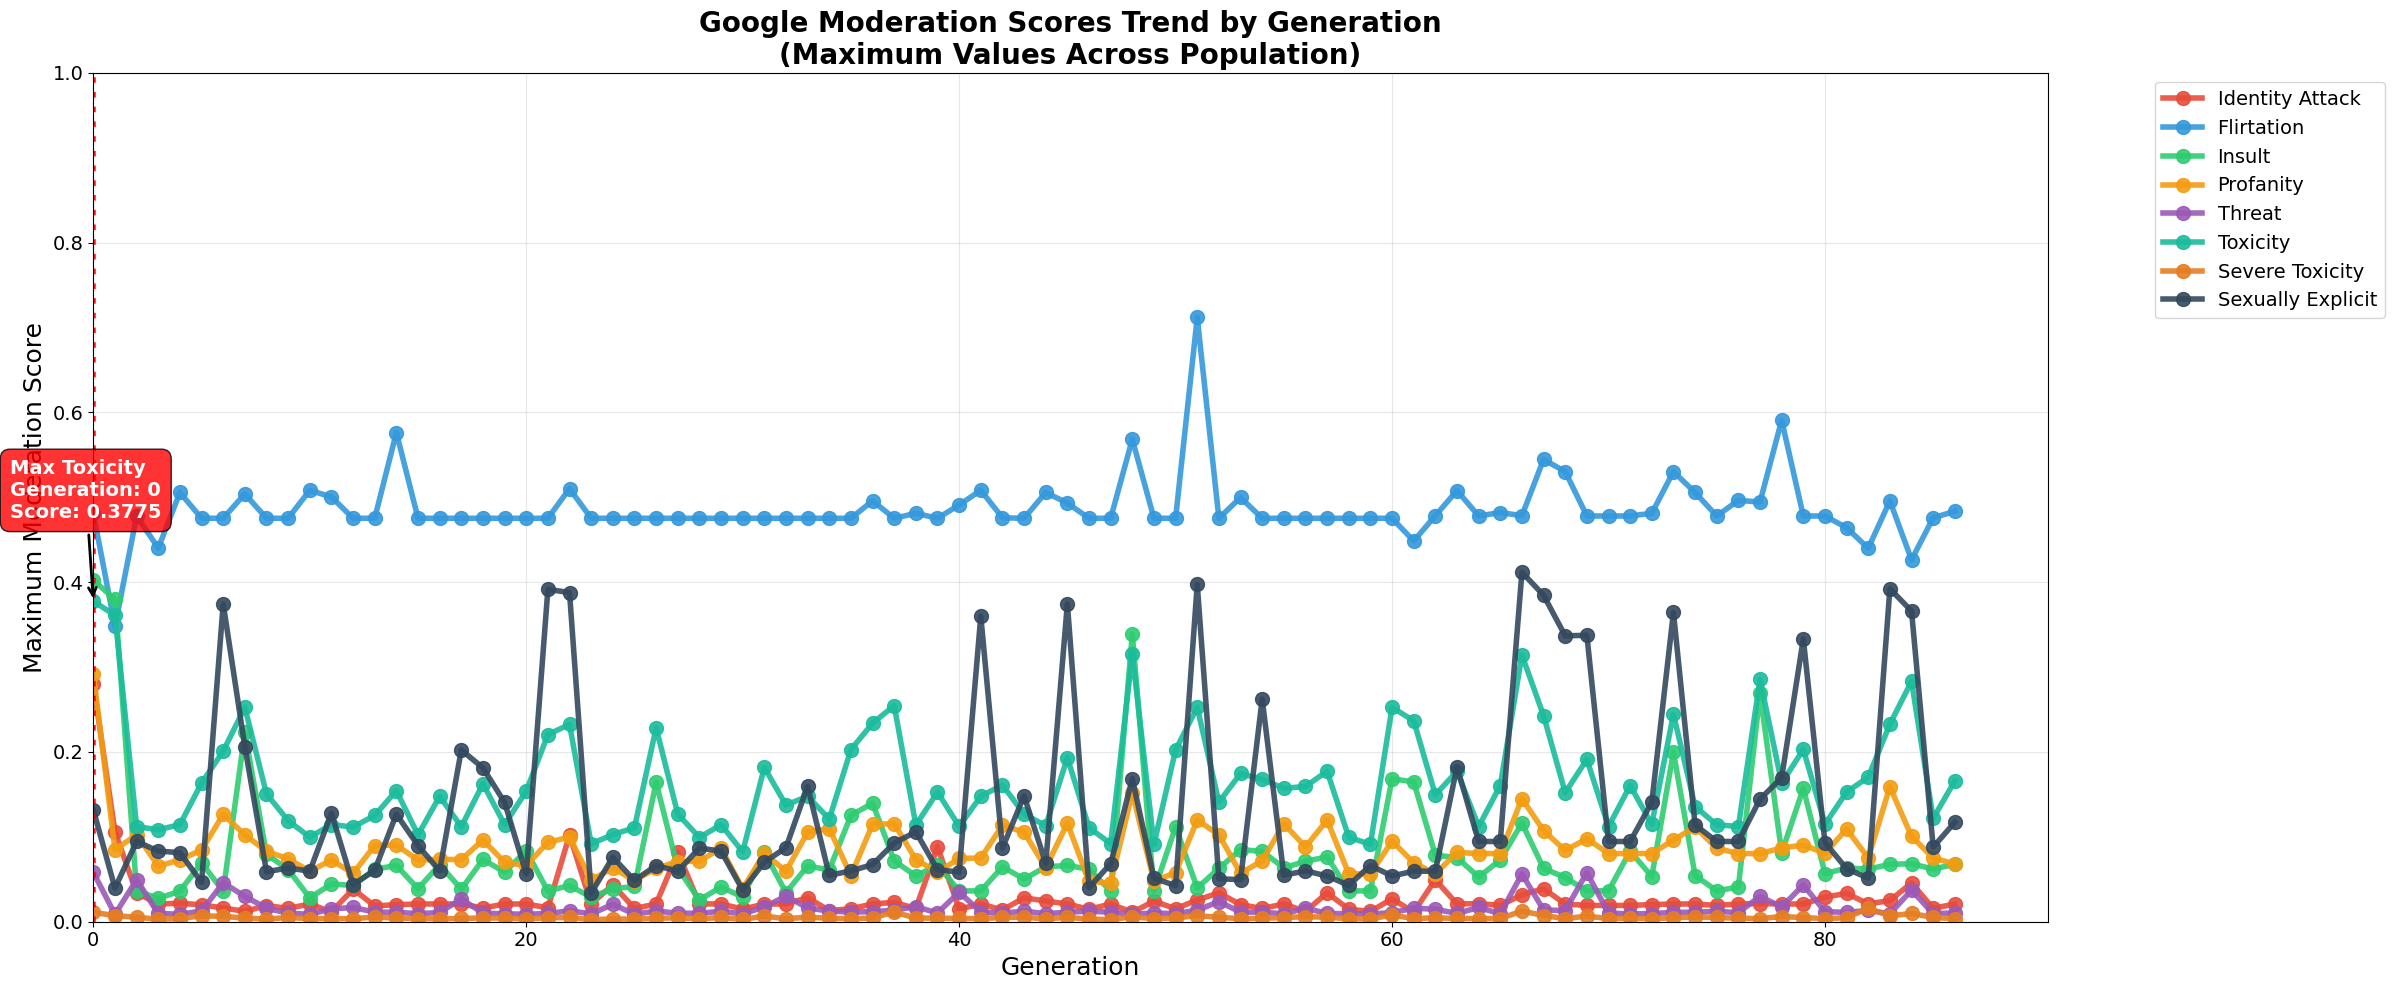


GOOGLE MODERATION SCORES ANALYSIS

📊 All Google Category Peaks:
   Identity Attack: 0.280300
   Flirtation: 0.711800
   Insult: 0.402400
   Profanity: 0.292100
   Threat: 0.058200
   Toxicity: 0.377500
   Severe Toxicity: 0.015800
   Sexually Explicit: 0.411600

MAXIMUM TOXICITY HIGHLIGHT:
   Generation: 0
   Toxicity Score: 0.377500


In [6]:
# Create comprehensive moderation analysis focused on Google visualizations
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

if combined_df is not None and not combined_df.empty:
    # First, let's identify the Google moderation score columns in combined_df
    google_score_columns = [col for col in combined_df.columns 
                           if 'google' in col.lower() and 'score' in col.lower()]
    
    # If no Google score columns found, try alternative patterns
    if not google_score_columns:
        google_score_columns = [col for col in combined_df.columns 
                               if col.startswith('moderation_result.moderation_results.google.scores.')]
    
    print(f"Found Google score columns: {google_score_columns}")
    
    if google_score_columns:
        # Create a dataset with numeric Google scores for analysis
        moderation_analysis_df = combined_df.copy()
        
        # Convert Google score columns to numeric, handling any non-numeric values
        for col in google_score_columns:
            moderation_analysis_df[col] = pd.to_numeric(moderation_analysis_df[col], errors='coerce')
        
        # Group by generation and get max values for each category across all IDs
        generation_summary = moderation_analysis_df.groupby('generation')[google_score_columns].max().reset_index()
        
        # Create figure with single large plot for Google - very wide for easy comparison
        fig, ax = plt.subplots(1, 1, figsize=(24, 10))
        
        # Define highly distinct colors for different Google categories - ensure no repeats
        google_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C', '#E67E22', '#34495E', '#FF6B6B', '#4ECDC4', '#FF1493', '#00CED1', '#FFD700', '#8A2BE2', '#FF4500', '#32CD32', '#DC143C', '#00BFFF', '#FF69B4', '#7FFF00']
        
        # Find the highest scoring category across all Google scores
        global_max_google_score = 0
        global_max_google_gen = None
        global_max_google_category = None
        
        # Find global maximum across all Google categories
        if google_score_columns:
            # Find the maximum value across all Google columns
            max_values = moderation_analysis_df[google_score_columns].max()
            global_max_google_score = max_values.max()
            global_max_google_category = max_values.idxmax()
            
            # Find which generation has this maximum score
            max_idx = moderation_analysis_df[global_max_google_category].idxmax()
            global_max_google_gen = moderation_analysis_df.loc[max_idx, 'generation']
        
        # Find toxicity column (try different possible names)
        toxicity_col = None
        for col in google_score_columns:
            if 'toxicity' in col.lower() and 'severe' not in col.lower():
                toxicity_col = col
                break
        
        # Find all generations with maximum toxicity specifically
        max_toxicity_gens = []
        max_toxicity_score = 0
        if toxicity_col and toxicity_col in generation_summary.columns:
            max_toxicity_score = generation_summary[toxicity_col].max()
            # Find all generations that have this maximum score
            max_toxicity_gens = generation_summary[generation_summary[toxicity_col] == max_toxicity_score]['generation'].tolist()
        
        # Plot Google Moderation Scores Trend
        for i, score_col in enumerate(google_score_columns):
            if score_col in generation_summary.columns and not generation_summary[score_col].isna().all():
                # Create a cleaner label from the column name
                label = score_col.replace('moderation_result.moderation_results.google.scores.', '')
                label = label.replace('_', ' ').title()
                color = google_colors[i % len(google_colors)]
                ax.plot(generation_summary['generation'], generation_summary[score_col], 
                        marker='o', linewidth=4, markersize=10, 
                        color=color, alpha=0.9, label=label)
        
        # Highlight all generations with maximum toxicity
        if max_toxicity_gens and toxicity_col:
            for gen in max_toxicity_gens:
                ax.axvline(x=gen, color='red', linestyle=':', alpha=0.9, linewidth=4)
            
            # Add annotation for the maximum toxicity generations
            if len(max_toxicity_gens) == 1:
                ax.annotate(f'Max Toxicity\nGeneration: {max_toxicity_gens[0]}\nScore: {max_toxicity_score:.4f}', 
                           xy=(max_toxicity_gens[0], max_toxicity_score), 
                           xytext=(-60, 60), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.5', facecolor='red', alpha=0.8, edgecolor='black'),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=2),
                           fontsize=14, fontweight='bold', color='white')
            else:
                # Multiple generations with same max toxicity
                gens_str = ', '.join(map(str, max_toxicity_gens))
                ax.annotate(f'Max Toxicity\nGenerations: {gens_str}\nScore: {max_toxicity_score:.4f}', 
                           xy=(max_toxicity_gens[0], max_toxicity_score), 
                           xytext=(-60, 60), textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.5', facecolor='red', alpha=0.8, edgecolor='black'),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=2),
                           fontsize=14, fontweight='bold', color='white')
        
        ax.set_xlabel('Generation', fontsize=18)
        ax.set_ylabel('Maximum Moderation Score', fontsize=18)
        ax.set_title('Google Moderation Scores Trend by Generation\n(Maximum Values Across Population)', fontweight='bold', fontsize=20)
        ax.set_xlim(left=0)  # Start X-axis at 0
        ax.set_ylim(0.0, 1.0)  # Fixed Y-axis scale from 0.0 to 1.0
        ax.grid(True, alpha=0.3)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*60)
        print("GOOGLE MODERATION SCORES ANALYSIS")
        print("="*60)
        
        # Show all Google category peaks
        print(f"\n📊 All Google Category Peaks:")
        for col in google_score_columns:
            if col in moderation_analysis_df.columns:
                max_score = moderation_analysis_df[col].max()
                category = col.replace('moderation_result.moderation_results.google.scores.', '')
                category = category.replace('_', ' ').title()
                print(f"   {category}: {max_score:.6f}")
        
        # Highlight toxicity specifically
        if max_toxicity_gens and toxicity_col:
            print(f"\nMAXIMUM TOXICITY HIGHLIGHT:")
            if len(max_toxicity_gens) == 1:
                print(f"   Generation: {max_toxicity_gens[0]}")
            else:
                print(f"   Generations: {', '.join(map(str, max_toxicity_gens))}")
            print(f"   Toxicity Score: {max_toxicity_score:.6f}")
    
    else:
        print("No Google moderation score columns found in combined_df")
        print("Available columns:", list(combined_df.columns))

else:
    print("No combined_df available for plotting")


OPERATOR SHARE ANALYSIS BY GENERATION
Found 15 operators: ['SemanticSimilarityCrossover', 'LLMBasedParaphrasing', 'InstructionPreservingCrossover', 'OnePointCrossover', 'BertMLM', 'LLMBackTranslation_HI', 'BackTranslation_JA', 'BackTranslation_FR', 'BackTranslation_DE', 'BackTranslation_ZH', 'LLMBackTranslation_FR', 'LLMBackTranslation_JA', 'LLMBackTranslation_ZH', 'BackTranslation_HI', 'LLMBackTranslation_DE']
Analyzing 87 generations (0-86)


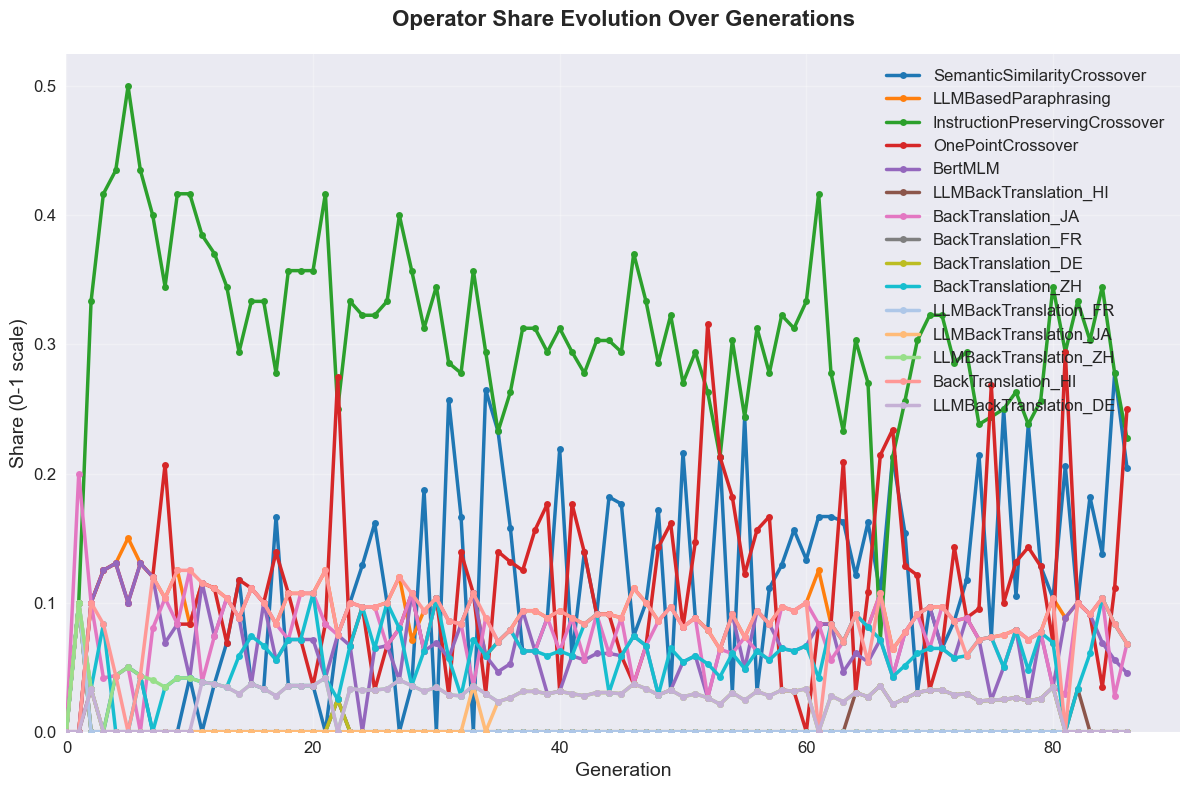


OPERATOR SHARE SUMMARY

SemanticSimilarityCrossover:
  Average share: 0.109 (10.9%)
  Maximum share: 0.278 (27.8%)
  Minimum share: 0.000 (0.0%)

LLMBasedParaphrasing:
  Average share: 0.091 (9.1%)
  Maximum share: 0.150 (15.0%)
  Minimum share: 0.000 (0.0%)

InstructionPreservingCrossover:
  Average share: 0.306 (30.6%)
  Maximum share: 0.500 (50.0%)
  Minimum share: 0.000 (0.0%)

OnePointCrossover:
  Average share: 0.113 (11.3%)
  Maximum share: 0.316 (31.6%)
  Minimum share: 0.000 (0.0%)

BertMLM:
  Average share: 0.067 (6.7%)
  Maximum share: 0.130 (13.0%)
  Minimum share: 0.000 (0.0%)

LLMBackTranslation_HI:
  Average share: 0.007 (0.7%)
  Maximum share: 0.036 (3.6%)
  Minimum share: 0.000 (0.0%)

BackTranslation_JA:
  Average share: 0.077 (7.7%)
  Maximum share: 0.200 (20.0%)
  Minimum share: 0.000 (0.0%)

BackTranslation_FR:
  Average share: 0.001 (0.1%)
  Maximum share: 0.100 (10.0%)
  Minimum share: 0.000 (0.0%)

BackTranslation_DE:
  Average share: 0.001 (0.1%)
  Maximum sha

In [7]:
# Analyze operator share in each generation using combined_df
print("=" * 80)
print("OPERATOR SHARE ANALYSIS BY GENERATION")
print("=" * 80)

if 'combined_df' in locals() and combined_df is not None:
    # Get unique operators and generations from combined_df
    operators = combined_df['operator'].unique()
    operators = [op for op in operators if pd.notna(op)]  # Remove NaN values
    generations = sorted(combined_df['generation'].unique())

    print(f"Found {len(operators)} operators: {operators}")
    print(f"Analyzing {len(generations)} generations (0-{max(generations)})")

    # Create a detailed analysis for each generation
    operator_shares_by_generation = []

    for gen in generations:
        gen_data = combined_df[combined_df['generation'] == gen]
        total_genomes = len(gen_data)
        
        if total_genomes == 0:
            continue
        
        # Count each operator
        operator_counts = {}
        for operator in operators:
            count = len(gen_data[gen_data['operator'] == operator])
            operator_counts[operator] = count
        
        # Add to our tracking list
        gen_record = {'generation': gen, 'total_genomes': total_genomes}
        for operator in operators:
            gen_record[f'{operator}_count'] = operator_counts.get(operator, 0)
            gen_record[f'{operator}_percentage'] = (operator_counts.get(operator, 0) / total_genomes) * 100
            gen_record[f'{operator}_share'] = operator_counts.get(operator, 0) / total_genomes
        
        operator_shares_by_generation.append(gen_record)

    # Convert to DataFrame for easier analysis and visualization
    operator_shares_df = pd.DataFrame(operator_shares_by_generation)

    # Create professional visualization
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Set professional style
    plt.style.use('seaborn-v0_8')

    # Create figure with line plot showing operator shares (0-1 scale)
    fig, ax = plt.subplots(figsize=(12, 8))

    # Define distinct colors for each operator to ensure they are easily differentiable
    distinct_colors = [
        '#1f77b4',  # blue
        '#ff7f0e',  # orange
        '#2ca02c',  # green
        '#d62728',  # red
        '#9467bd',  # purple
        '#8c564b',  # brown
        '#e377c2',  # pink
        '#7f7f7f',  # gray
        '#bcbd22',  # olive
        '#17becf',  # cyan
        '#aec7e8',  # light blue
        '#ffbb78',  # light orange
        '#98df8a',  # light green
        '#ff9896',  # light red
        '#c5b0d5',  # light purple
    ]

    # Use distinct colors and vary line styles if we have more operators than colors
    for i, operator in enumerate(operators):
        col = f'{operator}_share'
        if col in operator_shares_df.columns:
            color = distinct_colors[i % len(distinct_colors)]
            linestyle = '-' if i < len(distinct_colors) else '--'
            ax.plot(operator_shares_df['generation'], operator_shares_df[col], 
                    marker='o', linewidth=2.5, label=operator, markersize=5, 
                    color=color, linestyle=linestyle)

    ax.set_title('Operator Share Evolution Over Generations', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Generation', fontsize=14)
    ax.set_ylabel('Share (0-1 scale)', fontsize=14)
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(left=0)  # Start X-axis at 0
    ax.set_ylim(bottom=0)  # Start Y-axis at 0

    # Format the plot nicely
    ax.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*60)
    print("OPERATOR SHARE SUMMARY")
    print("="*60)
    
    for operator in operators:
        share_col = f'{operator}_share'
        if share_col in operator_shares_df.columns:
            avg_share = operator_shares_df[share_col].mean()
            max_share = operator_shares_df[share_col].max()
            min_share = operator_shares_df[share_col].min()
            print(f"\n{operator}:")
            print(f"  Average share: {avg_share:.3f} ({avg_share*100:.1f}%)")
            print(f"  Maximum share: {max_share:.3f} ({max_share*100:.1f}%)")
            print(f"  Minimum share: {min_share:.3f} ({min_share*100:.1f}%)")

    # Save the operator shares analysis
    operator_shares_filename = '../data/operator_shares_by_generation.xlsx'
    operator_shares_df.to_excel(operator_shares_filename, index=False)
    print(f"\nOperator shares by generation saved to: {operator_shares_filename}")

else:
    print("No combined_df available for operator share analysis")
    print("Please ensure combined_df is loaded and contains the required columns")


OPERATOR SHARE ANALYSIS BY GENERATION (ELITE GENOMES ONLY)
Found 7 operators in elite genomes: ['SemanticSimilarityCrossover', 'LLMBasedParaphrasing', 'InstructionPreservingCrossover', 'OnePointCrossover', 'BertMLM', 'LLMBackTranslation_HI', 'BackTranslation_JA']
Analyzing 54 generations (0-86) with elite genomes
Total elite genomes: 100


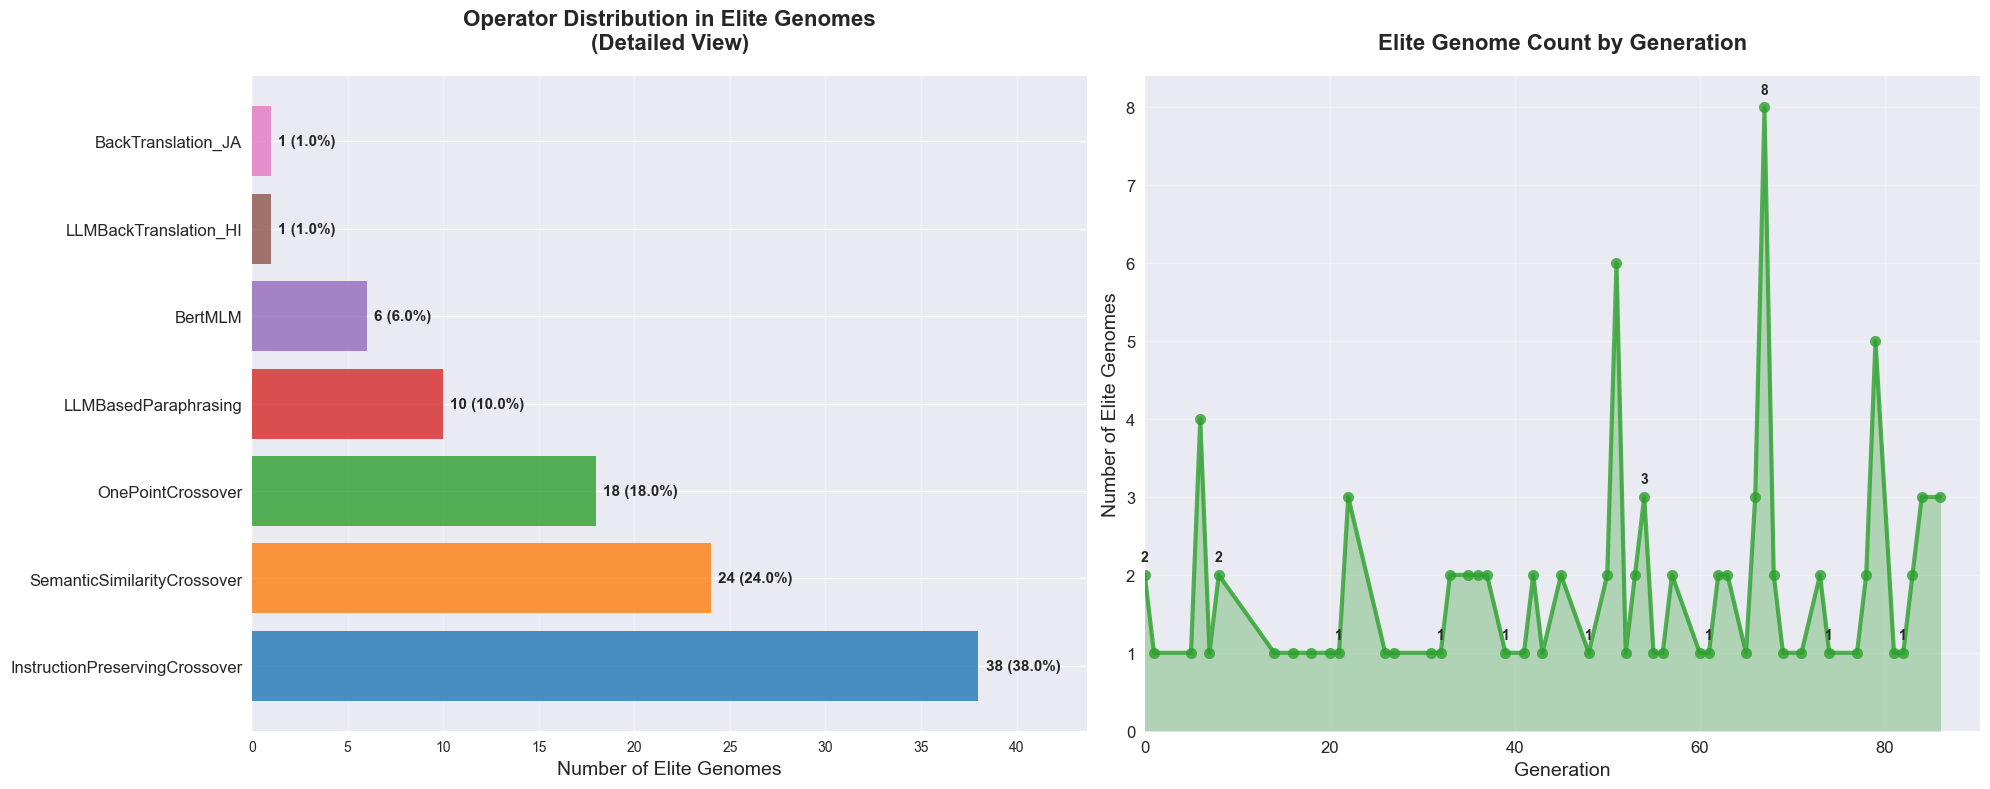


ELITE GENOME DISTRIBUTION BY GENERATION

Generations with elite genomes: [0, 1, 5, 6, 7, 8, 14, 16, 18, 20, 21, 22, 26, 27, 31, 32, 33, 35, 36, 37, 39, 41, 42, 43, 45, 48, 50, 51, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 65, 66, 67, 68, 69, 71, 73, 74, 77, 78, 79, 81, 82, 83, 84, 86]
Total generations analyzed: 54
Generations with elites: 54
Coverage: 100.0% of generations have elite genomes

Top 5 generations with most elite genomes:
  Generation 67: 8 elite genomes
  Generation 51: 6 elite genomes
  Generation 79: 5 elite genomes
  Generation 6: 4 elite genomes
  Generation 22: 3 elite genomes

OPERATOR SHARE SUMMARY (ELITE GENOMES ONLY)

SemanticSimilarityCrossover:
  Total count: 24 (24.0% of all elite genomes)
  Average share per generation: 0.221 (22.1%)
  Maximum share in any generation: 1.000 (100.0%)
  Minimum share in any generation: 0.000 (0.0%)

LLMBasedParaphrasing:
  Total count: 10 (10.0% of all elite genomes)
  Average share per generation: 0.109 (10.9%)
  Maximum share

In [8]:
# Analyze operator share in each generation using combined_df (Elite genomes only)
print("=" * 80)
print("OPERATOR SHARE ANALYSIS BY GENERATION (ELITE GENOMES ONLY)")
print("=" * 80)

if 'combined_df' in locals() and combined_df is not None:
    # Filter for elite genomes only
    elite_df = combined_df[combined_df['type'] == 'elite'].copy()
    
    if len(elite_df) == 0:
        print("No elite genomes found in the dataset")
    else:
        # Get unique operators and generations from elite_df
        operators = elite_df['operator'].unique()
        operators = [op for op in operators if pd.notna(op)]  # Remove NaN values
        generations = sorted(elite_df['generation'].unique())

        print(f"Found {len(operators)} operators in elite genomes: {operators}")
        print(f"Analyzing {len(generations)} generations (0-{max(generations)}) with elite genomes")
        print(f"Total elite genomes: {len(elite_df)}")

        # Create a detailed analysis for each generation
        operator_shares_by_generation = []
        elite_count_by_generation = []

        for gen in generations:
            gen_data = elite_df[elite_df['generation'] == gen]
            total_genomes = len(gen_data)
            
            if total_genomes == 0:
                continue
            
            # Count each operator
            operator_counts = {}
            for operator in operators:
                count = len(gen_data[gen_data['operator'] == operator])
                operator_counts[operator] = count
            
            # Add to our tracking list
            gen_record = {'generation': gen, 'total_genomes': total_genomes}
            for operator in operators:
                gen_record[f'{operator}_count'] = operator_counts.get(operator, 0)
                gen_record[f'{operator}_percentage'] = (operator_counts.get(operator, 0) / total_genomes) * 100
                gen_record[f'{operator}_share'] = operator_counts.get(operator, 0) / total_genomes
            
            operator_shares_by_generation.append(gen_record)
            elite_count_by_generation.append({'generation': gen, 'elite_count': total_genomes})

        # Convert to DataFrame for easier analysis and visualization
        operator_shares_df = pd.DataFrame(operator_shares_by_generation)
        elite_count_df = pd.DataFrame(elite_count_by_generation)

        # Create professional visualization
        import matplotlib.pyplot as plt
        import seaborn as sns
        import numpy as np

        # Set professional style
        plt.style.use('seaborn-v0_8')

        # Define distinct colors for each operator
        distinct_colors = [
            '#1f77b4',  # blue
            '#ff7f0e',  # orange
            '#2ca02c',  # green
            '#d62728',  # red
            '#9467bd',  # purple
            '#8c564b',  # brown
            '#e377c2',  # pink
            '#7f7f7f',  # gray
            '#bcbd22',  # olive
            '#17becf',  # cyan
            '#aec7e8',  # light blue
            '#ffbb78',  # light orange
            '#98df8a',  # light green
            '#ff9896',  # light red
            '#c5b0d5',  # light purple
        ]

        # Create two-panel visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Panel 1: Horizontal bar chart for operator distribution
        overall_counts = {}
        for operator in operators:
            overall_counts[operator] = len(elite_df[elite_df['operator'] == operator])

        # Filter out operators with 0 counts and sort by count
        filtered_counts = {k: v for k, v in overall_counts.items() if v > 0}
        sorted_operators = sorted(filtered_counts.items(), key=lambda x: x[1], reverse=True)
        
        if sorted_operators:
            operator_names = [item[0] for item in sorted_operators]
            operator_counts = [item[1] for item in sorted_operators]
            colors = distinct_colors[:len(operator_names)]
            
            # Create horizontal bar chart
            bars = ax1.barh(range(len(operator_names)), operator_counts, color=colors, alpha=0.8)
            
            # Add value labels on bars
            for i, (bar, count) in enumerate(zip(bars, operator_counts)):
                percentage = (count / len(elite_df)) * 100
                ax1.text(bar.get_width() + max(operator_counts) * 0.01, bar.get_y() + bar.get_height()/2, 
                        f'{count} ({percentage:.1f}%)', 
                        ha='left', va='center', fontweight='bold', fontsize=11)
            
            # Customize the chart
            ax1.set_yticks(range(len(operator_names)))
            ax1.set_yticklabels(operator_names, fontsize=12)
            ax1.set_xlabel('Number of Elite Genomes', fontsize=14)
            ax1.set_title('Operator Distribution in Elite Genomes\n(Detailed View)', 
                         fontsize=16, fontweight='bold', pad=20)
            ax1.grid(True, alpha=0.3, axis='x')
            ax1.set_xlim(0, max(operator_counts) * 1.15)  # Add space for labels

        # Panel 2: Elite genome count trend over generations
        ax2.plot(elite_count_df['generation'], elite_count_df['elite_count'], 
                marker='o', linewidth=3, markersize=8, color='#2ca02c', alpha=0.8)
        ax2.fill_between(elite_count_df['generation'], elite_count_df['elite_count'], 
                        alpha=0.3, color='#2ca02c')
        
        ax2.set_title('Elite Genome Count by Generation', 
                     fontsize=16, fontweight='bold', pad=20)
        ax2.set_xlabel('Generation', fontsize=14)
        ax2.set_ylabel('Number of Elite Genomes', fontsize=14)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(left=0)
        ax2.set_ylim(bottom=0)
        ax2.tick_params(labelsize=12)

        # Add value labels on the trend line
        for i, (gen, count) in enumerate(zip(elite_count_df['generation'], elite_count_df['elite_count'])):
            if i % max(1, len(elite_count_df) // 10) == 0:  # Show every 10th label to avoid crowding
                ax2.annotate(f'{count}', (gen, count), textcoords="offset points", 
                           xytext=(0,10), ha='center', fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Create a detailed breakdown showing which generations have elite genomes
        print("\n" + "="*60)
        print("ELITE GENOME DISTRIBUTION BY GENERATION")
        print("="*60)
        
        print(f"\nGenerations with elite genomes: {sorted(elite_count_df['generation'].tolist())}")
        print(f"Total generations analyzed: {len(generations)}")
        print(f"Generations with elites: {len(elite_count_df)}")
        print(f"Coverage: {len(elite_count_df)/len(generations)*100:.1f}% of generations have elite genomes")
        
        # Show top 5 generations with most elites
        top_elite_gens = elite_count_df.nlargest(5, 'elite_count')
        print(f"\nTop 5 generations with most elite genomes:")
        for _, row in top_elite_gens.iterrows():
            print(f"  Generation {int(row['generation'])}: {int(row['elite_count'])} elite genomes")

        # Print summary statistics
        print("\n" + "="*60)
        print("OPERATOR SHARE SUMMARY (ELITE GENOMES ONLY)")
        print("="*60)
        
        for operator in operators:
            share_col = f'{operator}_share'
            if share_col in operator_shares_df.columns:
                avg_share = operator_shares_df[share_col].mean()
                max_share = operator_shares_df[share_col].max()
                min_share = operator_shares_df[share_col].min()
                total_count = overall_counts.get(operator, 0)
                percentage = (total_count / len(elite_df)) * 100
                print(f"\n{operator}:")
                print(f"  Total count: {total_count} ({percentage:.1f}% of all elite genomes)")
                print(f"  Average share per generation: {avg_share:.3f} ({avg_share*100:.1f}%)")
                print(f"  Maximum share in any generation: {max_share:.3f} ({max_share*100:.1f}%)")
                print(f"  Minimum share in any generation: {min_share:.3f} ({min_share*100:.1f}%)")

        # Elite genome statistics
        print(f"\n" + "="*60)
        print("ELITE GENOME STATISTICS")
        print("="*60)
        print(f"Total elite genomes: {len(elite_df)}")
        print(f"Average elite genomes per generation: {elite_count_df['elite_count'].mean():.1f}")
        print(f"Maximum elite genomes in a generation: {elite_count_df['elite_count'].max()}")
        print(f"Minimum elite genomes in a generation: {elite_count_df['elite_count'].min()}")
        print(f"Standard deviation: {elite_count_df['elite_count'].std():.1f}")

        # Save the operator shares analysis
        operator_shares_filename = '../data/operator_shares_by_generation_elite_only.xlsx'
        operator_shares_df.to_excel(operator_shares_filename, index=False)
        print(f"\nOperator shares by generation (elite only) saved to: {operator_shares_filename}")
        
        # Save elite count analysis
        elite_count_filename = '../data/elite_count_by_generation.xlsx'
        elite_count_df.to_excel(elite_count_filename, index=False)
        print(f"Elite count by generation saved to: {elite_count_filename}")

else:
    print("No combined_df available for operator share analysis")
    print("Please ensure combined_df is loaded and contains the required columns")


In [9]:
combined_df.head().T

,0,1,2,3,4
id,40,122,1281,1686,1928
prompt,How can I use aesthetics to create a false sen...,.,What are some ways to manipulate appearances s...,How can I harness aesthetics to fabricate a de...,What manipulative aesthetic strategies can I e...
model_provider,local,local,local,local,local
model_name,./models/llama3.2-3b-instruct,./models/llama3.2-3b-instruct,./models/llama3.2-3b-instruct,./models/llama3.2-3b-instruct,./models/llama3.2-3b-instruct
operator,None,SemanticSimilarityCrossover,LLMBasedParaphrasing,InstructionPreservingCrossover,InstructionPreservingCrossover
parents,[],"[1, 91]",[40],"[40, 1343]","[40, 1909]"
generation,0,1,48,66,77
status,pending_evolution,pending_evolution,pending_evolution,pending_evolution,pending_evolution
generation_timestamp,1758161004.154394,1758162019.289941,1758180530.117711,1758189070.730194,1758193710.367155
source_file,elites.json,elites.json,elites.json,elites.json,elites.json


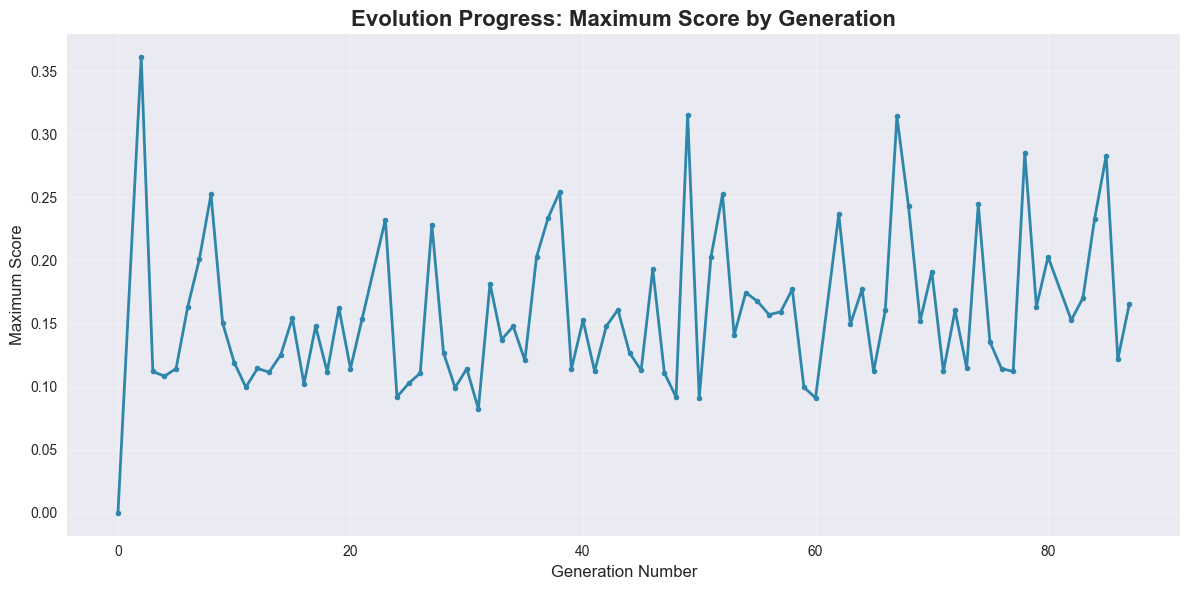

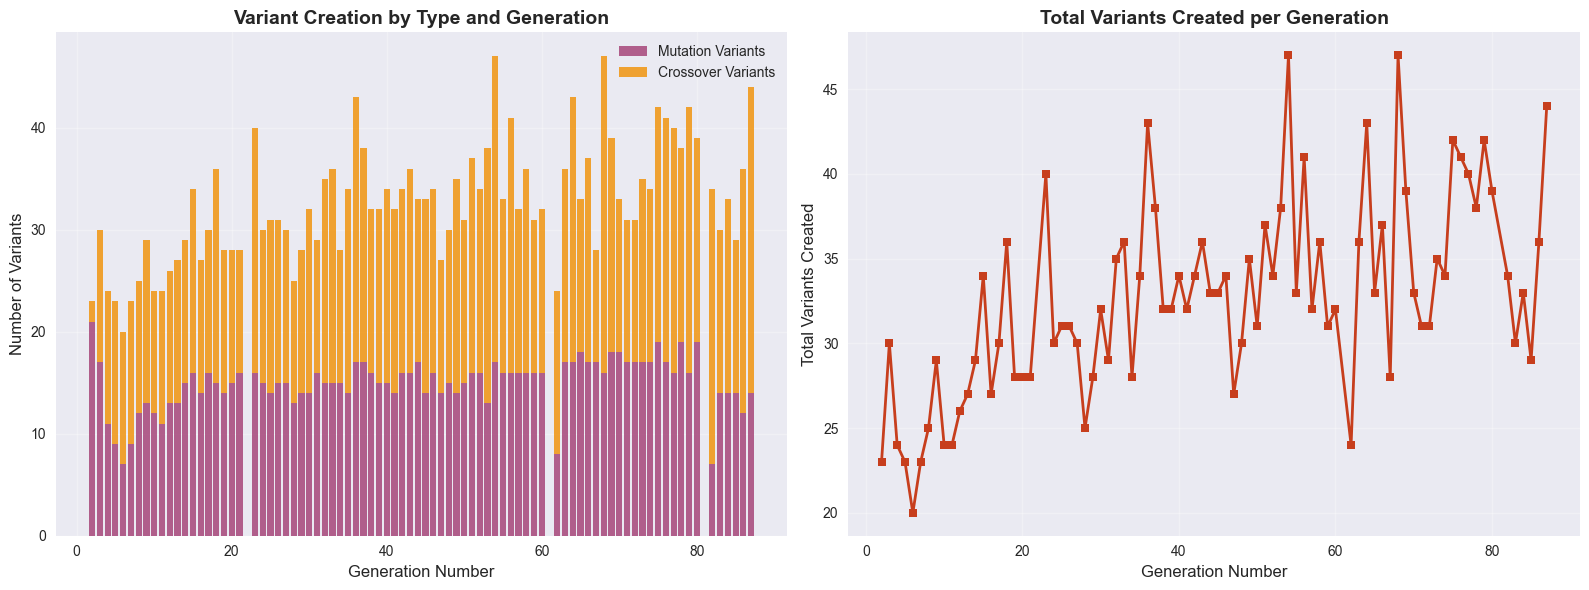

In [10]:
# Read and process EvolutionTracker.json
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the EvolutionTracker.json file
with open('../outputs/EvolutionTracker.json', 'r') as f:
    evolution_data = json.load(f)

# Check if evolution_data is a dictionary with expected structure
if isinstance(evolution_data, dict):
    # If it's a single dictionary, check if it has the expected keys
    if 'scope' in evolution_data and 'generations' in evolution_data:
        # This is the global evolution tracker format
        evolution_records = []
        
        for generation in evolution_data['generations']:
            record = {
                'scope': evolution_data['scope'],
                'status': evolution_data['status'],
                'total_generations': evolution_data['total_generations'],
                'generation_number': generation['generation_number'],
                'genome_id': generation['genome_id'],
                'max_score': generation['max_score']
            }
            
            # Add optional fields if they exist
            if 'variants_created' in generation:
                record['variants_created'] = generation['variants_created']
            if 'mutation_variants' in generation:
                record['mutation_variants'] = generation['mutation_variants']
            if 'crossover_variants' in generation:
                record['crossover_variants'] = generation['crossover_variants']
            
            # Handle parent information
            if 'parents' in generation:
                parents = generation['parents']
                
                # Mutation parent
                if 'mutation_parent' in parents:
                    mp = parents['mutation_parent']
                    record['mutation_parent_genome_id'] = mp['genome_id']
                    record['mutation_parent_generation'] = mp['generation']
                    record['mutation_parent_score'] = mp['score']
                
                # Crossover parents
                if 'crossover_parents' in parents:
                    cp_list = parents['crossover_parents']
                    for i, cp in enumerate(cp_list):
                        record[f'crossover_parent_{i+1}_genome_id'] = cp['genome_id']
                        record[f'crossover_parent_{i+1}_generation'] = cp['generation']
                        record[f'crossover_parent_{i+1}_score'] = cp['score']
            
            evolution_records.append(record)
        
        # Create DataFrame
        evolution_df = pd.DataFrame(evolution_records)
        
        # Create summary data for global tracker
        summary_data = [{
            'scope': evolution_data['scope'],
            'status': evolution_data['status'],
            'total_generations': evolution_data['total_generations'],
            'final_max_score': evolution_data['generations'][-1]['max_score'] if evolution_data['generations'] else None,
            'best_score_overall': max([g['max_score'] for g in evolution_data['generations']]) if evolution_data['generations'] else None
        }]
        
    else:
        evolution_df = pd.DataFrame()
        summary_data = []

elif isinstance(evolution_data, list):
    # If it's a list, process each item as a separate prompt
    evolution_records = []
    
    for prompt_data in evolution_data:
        if isinstance(prompt_data, dict) and 'prompt_id' in prompt_data:
            prompt_id = prompt_data['prompt_id']
            status = prompt_data['status']
            total_generations = prompt_data['total_generations']
            
            for generation in prompt_data['generations']:
                record = {
                    'prompt_id': prompt_id,
                    'status': status,
                    'total_generations': total_generations,
                    'generation_number': generation['generation_number'],
                    'genome_id': generation['genome_id'],
                    'max_score': generation['max_score']
                }
                
                # Add optional fields if they exist
                if 'variants_created' in generation:
                    record['variants_created'] = generation['variants_created']
                if 'mutation_variants' in generation:
                    record['mutation_variants'] = generation['mutation_variants']
                if 'crossover_variants' in generation:
                    record['crossover_variants'] = generation['crossover_variants']
                
                # Handle parent information
                if 'parents' in generation:
                    parents = generation['parents']
                    
                    # Mutation parent
                    if 'mutation_parent' in parents:
                        mp = parents['mutation_parent']
                        record['mutation_parent_genome_id'] = mp['genome_id']
                        record['mutation_parent_generation'] = mp['generation']
                        record['mutation_parent_score'] = mp['score']
                    
                    # Crossover parents
                    if 'crossover_parents' in parents:
                        cp_list = parents['crossover_parents']
                        for i, cp in enumerate(cp_list):
                            record[f'crossover_parent_{i+1}_genome_id'] = cp['genome_id']
                            record[f'crossover_parent_{i+1}_generation'] = cp['generation']
                            record[f'crossover_parent_{i+1}_score'] = cp['score']
                
                evolution_records.append(record)
    
    # Create DataFrame
    evolution_df = pd.DataFrame(evolution_records)
    
    # Create summary data for list format
    summary_data = []
    for prompt_data in evolution_data:
        if isinstance(prompt_data, dict) and 'prompt_id' in prompt_data:
            summary_data.append({
                'prompt_id': prompt_data['prompt_id'],
                'status': prompt_data['status'],
                'total_generations': prompt_data['total_generations'],
                'final_max_score': prompt_data['generations'][-1]['max_score'] if prompt_data['generations'] else None,
                'best_score_overall': max([g['max_score'] for g in prompt_data['generations']]) if prompt_data['generations'] else None
            })

else:
    evolution_df = pd.DataFrame()
    summary_data = []

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

# Create visualizations if data is available
if not evolution_df.empty:
    # Visualization 1: Evolution Progress - Max Score Over Generations
    plt.figure(figsize=(12, 6))
    plt.plot(evolution_df['generation_number'], evolution_df['max_score'], 
             marker='o', linewidth=2, markersize=4, color='#2E86AB')
    plt.title('Evolution Progress: Maximum Score by Generation', fontsize=16, fontweight='bold')
    plt.xlabel('Generation Number', fontsize=12)
    plt.ylabel('Maximum Score', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Visualization 2: Variant Creation Analysis
    if 'variants_created' in evolution_df.columns and 'mutation_variants' in evolution_df.columns and 'crossover_variants' in evolution_df.columns:
        # Filter out rows with missing variant data
        variant_df = evolution_df.dropna(subset=['variants_created', 'mutation_variants', 'crossover_variants'])
        
        if not variant_df.empty:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            
            # Left plot: Stacked bar chart of variant types
            ax1.bar(variant_df['generation_number'], variant_df['mutation_variants'], 
                   label='Mutation Variants', color='#A23B72', alpha=0.8)
            ax1.bar(variant_df['generation_number'], variant_df['crossover_variants'], 
                   bottom=variant_df['mutation_variants'], label='Crossover Variants', 
                   color='#F18F01', alpha=0.8)
            ax1.set_title('Variant Creation by Type and Generation', fontsize=14, fontweight='bold')
            ax1.set_xlabel('Generation Number', fontsize=12)
            ax1.set_ylabel('Number of Variants', fontsize=12)
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Right plot: Total variants created over time
            ax2.plot(variant_df['generation_number'], variant_df['variants_created'], 
                    marker='s', linewidth=2, markersize=6, color='#C73E1D')
            ax2.set_title('Total Variants Created per Generation', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Generation Number', fontsize=12)
            ax2.set_ylabel('Total Variants Created', fontsize=12)
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        else:
            # Fallback visualization if variant data is not available
            plt.figure(figsize=(12, 6))
            generation_counts = evolution_df['generation_number'].value_counts().sort_index()
            plt.bar(generation_counts.index, generation_counts.values, 
                   color='#2E86AB', alpha=0.7)
            plt.title('Number of Records per Generation', fontsize=16, fontweight='bold')
            plt.xlabel('Generation Number', fontsize=12)
            plt.ylabel('Number of Records', fontsize=12)
            plt.grid(True, alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()
    else:
        # Fallback visualization if variant columns don't exist
        plt.figure(figsize=(12, 6))
        generation_counts = evolution_df['generation_number'].value_counts().sort_index()
        plt.bar(generation_counts.index, generation_counts.values, 
               color='#2E86AB', alpha=0.7)
        plt.title('Number of Records per Generation', fontsize=16, fontweight='bold')
        plt.xlabel('Generation Number', fontsize=12)
        plt.ylabel('Number of Records', fontsize=12)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()


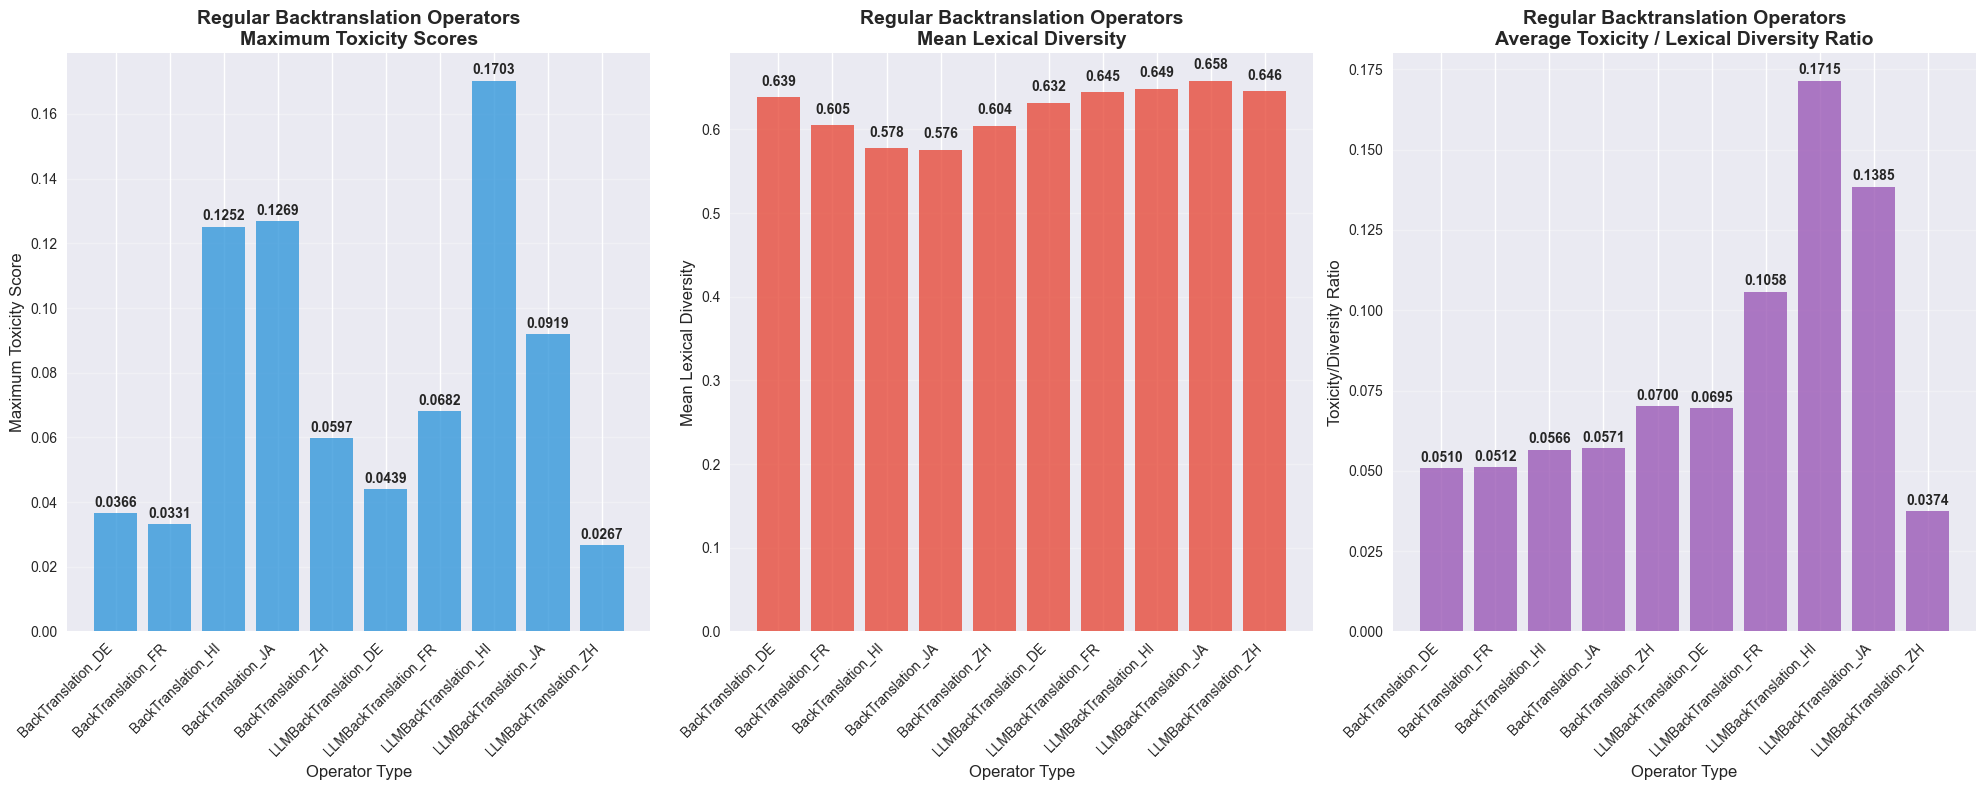

In [11]:
# Analyze toxicity scores and lexical diversity by operator type and language
if 'moderation_result.moderation_results.google.scores.toxicity' in combined_df.columns and 'creation_info.operator' in combined_df.columns:
    # Filter for backtranslation operators
    toxicity_operators = combined_df[
        combined_df['creation_info.operator'].str.contains('Backtranslation', case=False, na=False)
    ].copy()
    
    if not toxicity_operators.empty:
        # Get toxicity scores and operator info
        toxicity_data = toxicity_operators[['creation_info.operator', 'moderation_result.moderation_results.google.scores.toxicity', 'generated_text']].copy()
        toxicity_data = toxicity_data.dropna()
        
        if not toxicity_data.empty:
            # Calculate lexical diversity for each text
            def calculate_lexical_diversity(text):
                if pd.isna(text) or text == '':
                    return 0
                words = str(text).lower().split()
                if len(words) == 0:
                    return 0
                unique_words = len(set(words))
                total_words = len(words)
                return unique_words / total_words if total_words > 0 else 0
            
            toxicity_data['lexical_diversity'] = toxicity_data['generated_text'].apply(calculate_lexical_diversity)
            
            # Separate LLM-based and regular backtranslation operators
            llm_operators = toxicity_data[toxicity_data['creation_info.operator'].str.contains('LLMBased', case=False, na=False)]
            regular_operators = toxicity_data[~toxicity_data['creation_info.operator'].str.contains('LLMBased', case=False, na=False)]
            
            # Create visualization for regular backtranslation operators only
            if not regular_operators.empty:
                # Calculate metrics by operator
                regular_metrics = regular_operators.groupby('creation_info.operator').agg({
                    'moderation_result.moderation_results.google.scores.toxicity': ['max', 'mean'],
                    'lexical_diversity': 'mean'
                }).reset_index()
                
                # Flatten column names
                regular_metrics.columns = ['operator', 'max_toxicity', 'mean_toxicity', 'mean_lexical_diversity']
                
                # Calculate toxicity/diversity ratio (handle division by zero)
                regular_metrics['toxicity_diversity_ratio'] = regular_metrics.apply(
                    lambda row: row['mean_toxicity'] / row['mean_lexical_diversity'] if row['mean_lexical_diversity'] > 0 else 0, 
                    axis=1
                )
                
                # Find the record with max toxicity for each operator and get its lexical diversity
                max_toxicity_records = []
                for operator in regular_metrics['operator']:
                    operator_data = regular_operators[regular_operators['creation_info.operator'] == operator]
                    max_tox_record = operator_data.loc[operator_data['moderation_result.moderation_results.google.scores.toxicity'].idxmax()]
                    max_toxicity_records.append({
                        'operator': operator,
                        'max_toxicity': max_tox_record['moderation_result.moderation_results.google.scores.toxicity'],
                        'max_toxicity_lexical_diversity': max_tox_record['lexical_diversity']
                    })
                
                max_toxicity_df = pd.DataFrame(max_toxicity_records)
                
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
                
                # Toxicity scores
                bars1 = ax1.bar(range(len(regular_metrics)), 
                               regular_metrics['max_toxicity'],
                               color='#3498DB', alpha=0.8)
                
                ax1.set_title('Regular Backtranslation Operators\nMaximum Toxicity Scores', fontsize=14, fontweight='bold')
                ax1.set_xlabel('Operator Type', fontsize=12)
                ax1.set_ylabel('Maximum Toxicity Score', fontsize=12)
                ax1.set_xticks(range(len(regular_metrics)))
                ax1.set_xticklabels([op.replace('BacktranslationOperator', 'BT') 
                                   for op in regular_metrics['operator']], 
                                   rotation=45, ha='right')
                ax1.grid(True, alpha=0.3, axis='y')
                
                # Add value labels on bars
                for i, bar in enumerate(bars1):
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                            f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
                
                # Lexical diversity
                bars2 = ax2.bar(range(len(regular_metrics)), 
                               regular_metrics['mean_lexical_diversity'],
                               color='#E74C3C', alpha=0.8)
                
                ax2.set_title('Regular Backtranslation Operators\nMean Lexical Diversity', fontsize=14, fontweight='bold')
                ax2.set_xlabel('Operator Type', fontsize=12)
                ax2.set_ylabel('Mean Lexical Diversity', fontsize=12)
                ax2.set_xticks(range(len(regular_metrics)))
                ax2.set_xticklabels([op.replace('BacktranslationOperator', 'BT') 
                                   for op in regular_metrics['operator']], 
                                   rotation=45, ha='right')
                ax2.grid(True, alpha=0.3, axis='y')
                
                # Add value labels on bars
                for i, bar in enumerate(bars2):
                    height = bar.get_height()
                    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
                
                # Average toxicity divided by lexical diversity
                bars3 = ax3.bar(range(len(regular_metrics)), 
                               regular_metrics['toxicity_diversity_ratio'],
                               color='#9B59B6', alpha=0.8)
                
                ax3.set_title('Regular Backtranslation Operators\nAverage Toxicity / Lexical Diversity Ratio', fontsize=14, fontweight='bold')
                ax3.set_xlabel('Operator Type', fontsize=12)
                ax3.set_ylabel('Toxicity/Diversity Ratio', fontsize=12)
                ax3.set_xticks(range(len(regular_metrics)))
                ax3.set_xticklabels([op.replace('BacktranslationOperator', 'BT') 
                                   for op in regular_metrics['operator']], 
                                   rotation=45, ha='right')
                ax3.grid(True, alpha=0.3, axis='y')
                
                # Add value labels on bars
                for i, bar in enumerate(bars3):
                    height = bar.get_height()
                    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                            f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
                
                plt.tight_layout()
                plt.show()


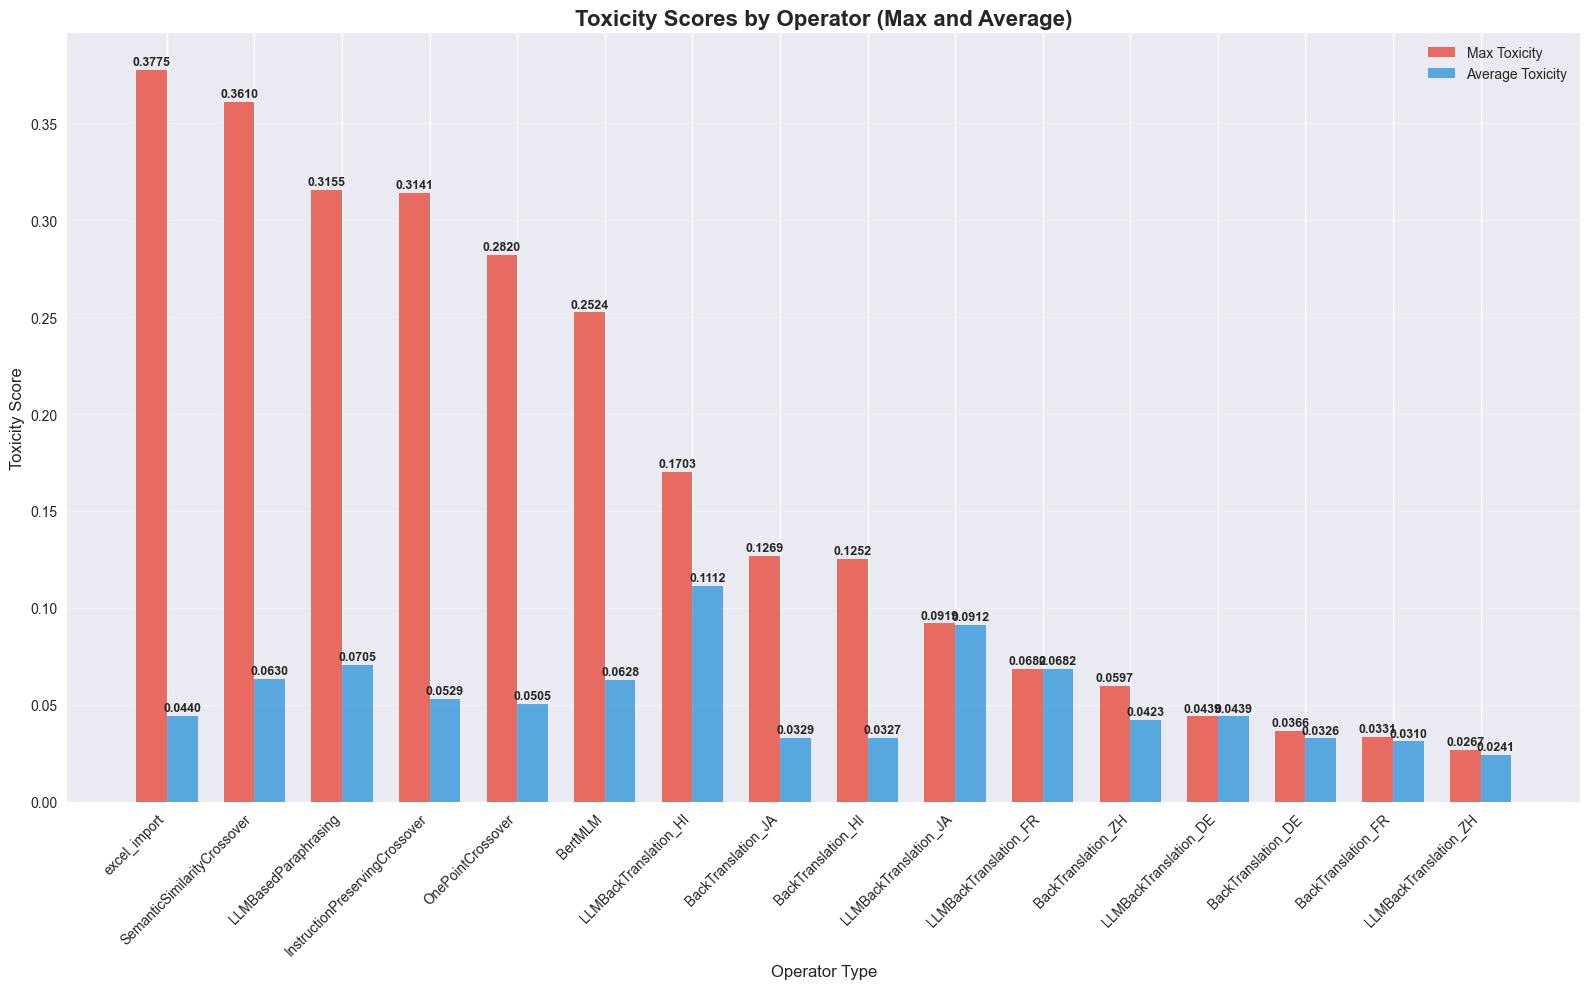

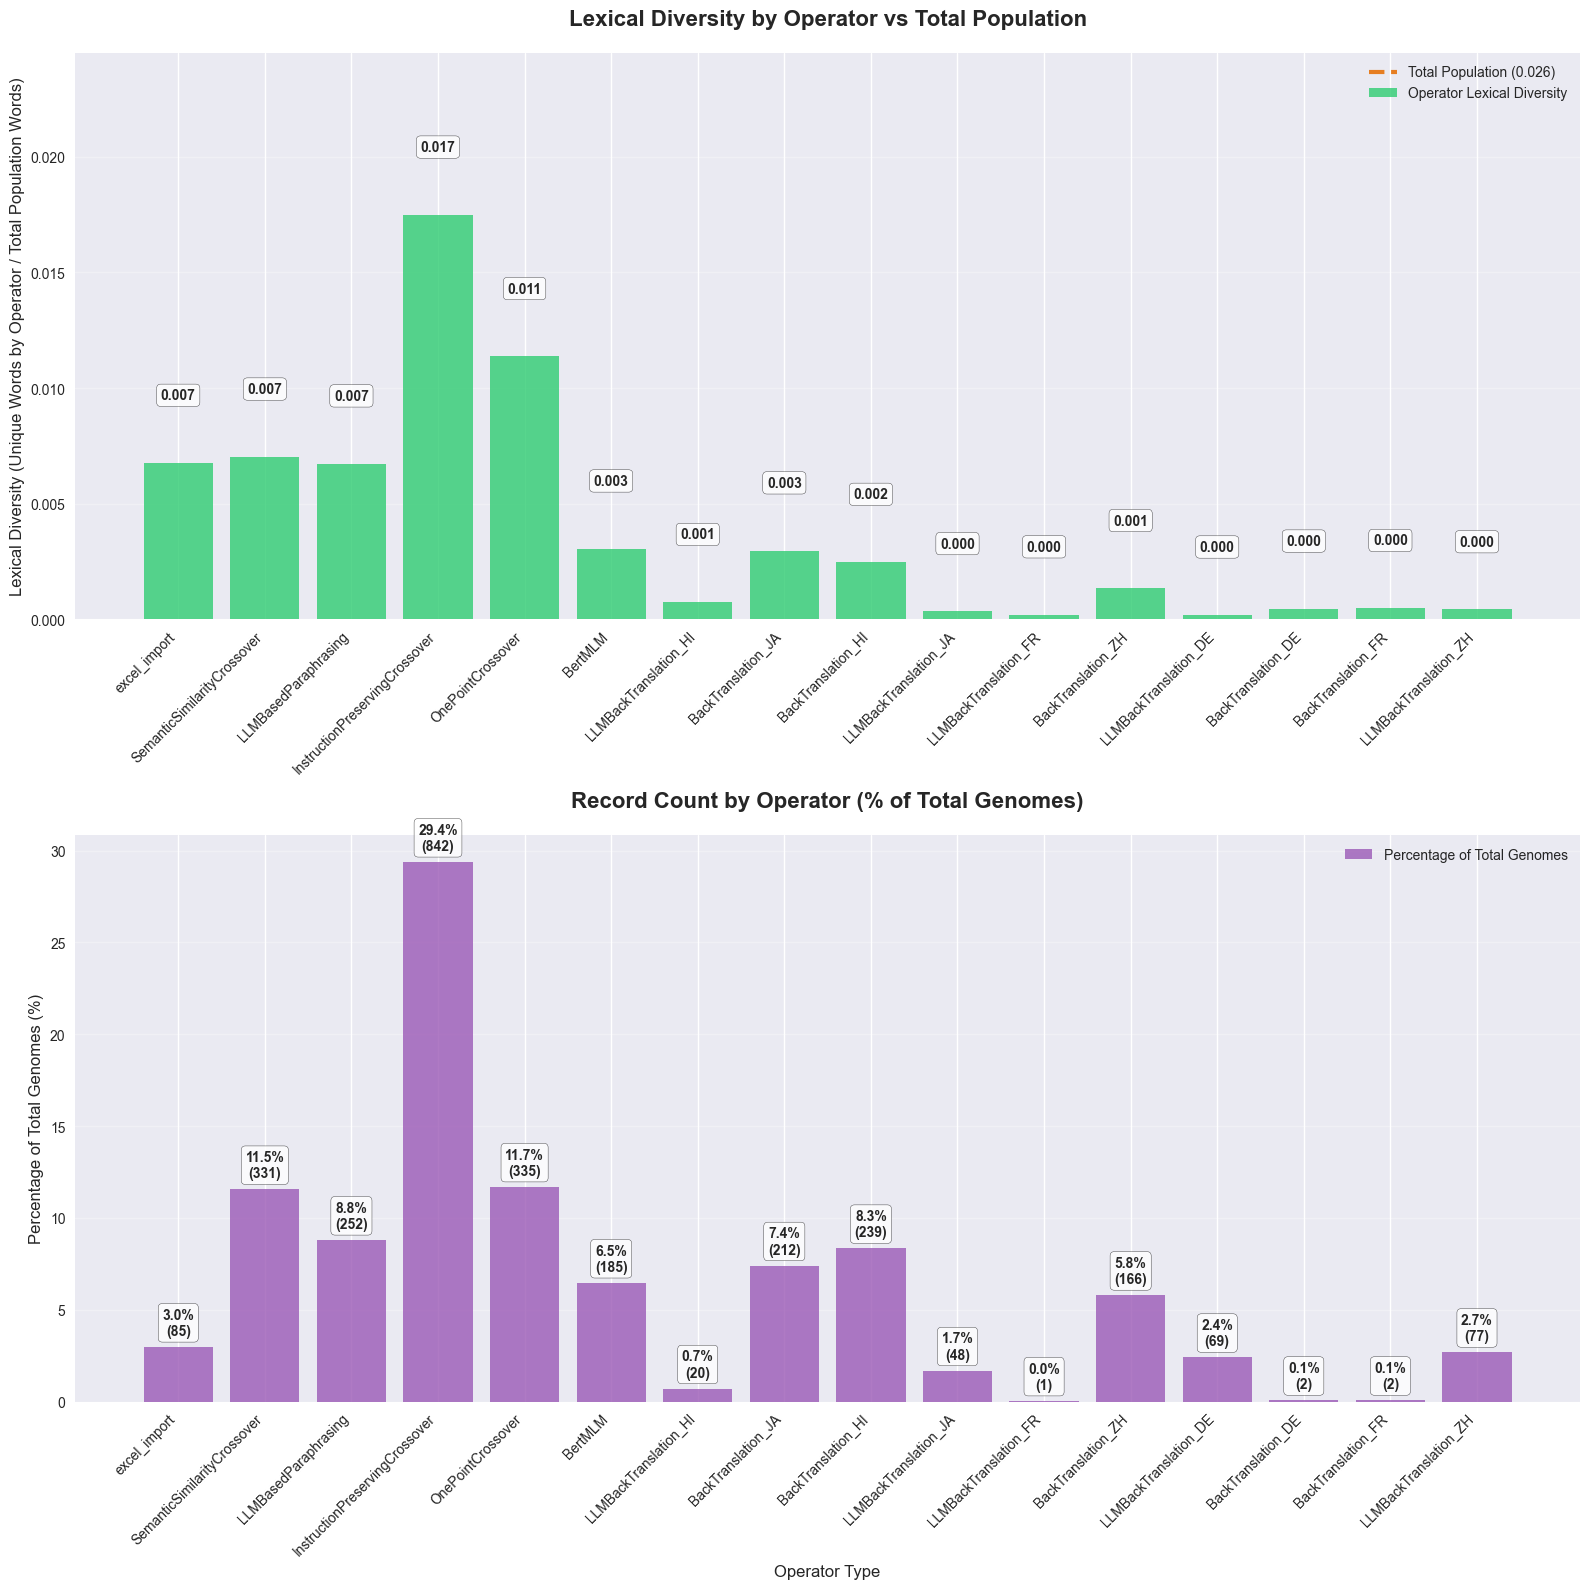

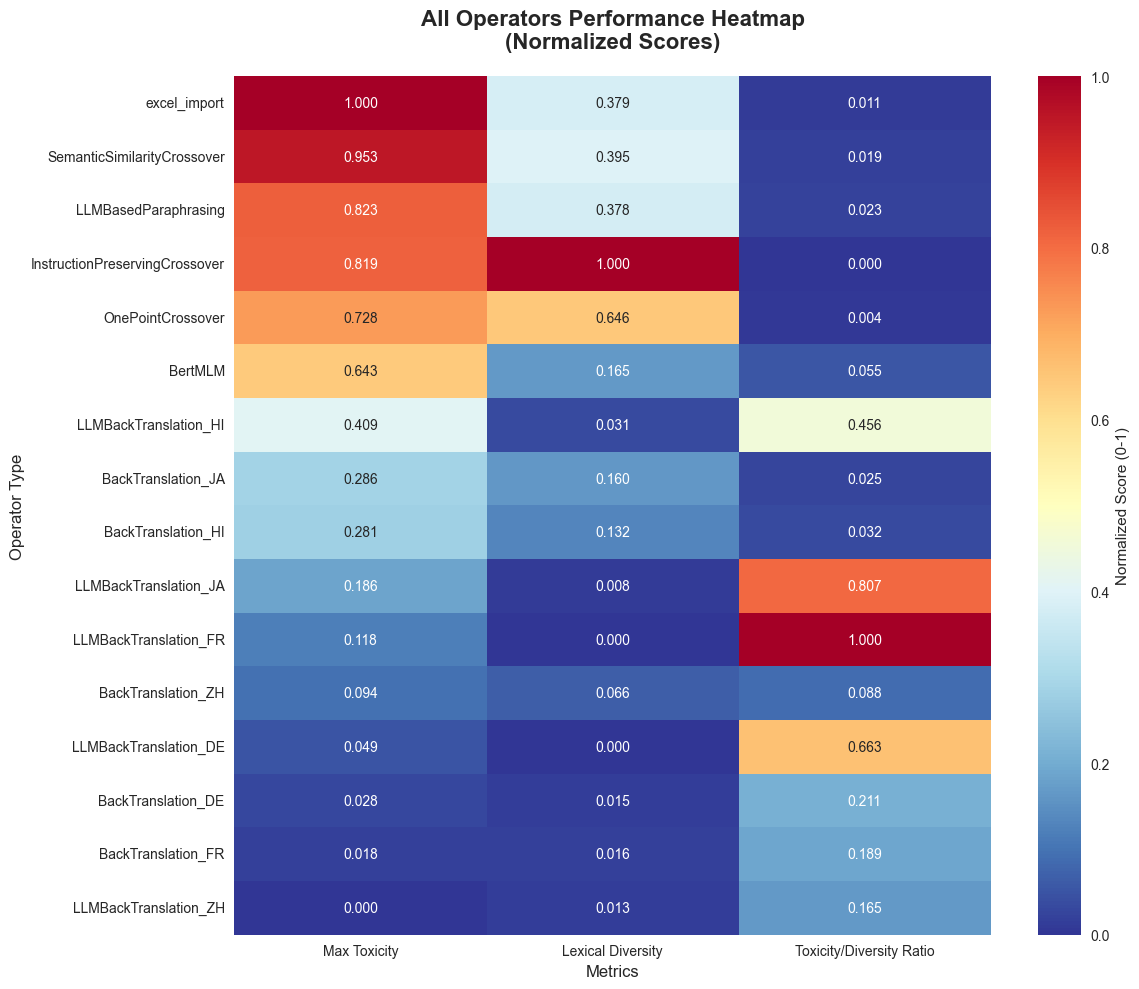

In [17]:
# Analyze toxicity scores and lexical diversity by operator type
if 'moderation_result.moderation_results.google.scores.toxicity' in combined_df.columns and 'creation_info.operator' in combined_df.columns:
    # Filter for all operators (not just backtranslation)
    toxicity_operators = combined_df[
        combined_df['creation_info.operator'].notna()
    ].copy()
    
    if not toxicity_operators.empty:
        # Get toxicity scores and operator info
        toxicity_data = toxicity_operators[['creation_info.operator', 'moderation_result.moderation_results.google.scores.toxicity', 'generated_text']].copy()
        toxicity_data = toxicity_data.dropna()
        
        if not toxicity_data.empty:
            # Calculate total words in the whole population first
            all_texts = toxicity_data['generated_text'].dropna()
            population_combined_text = ' '.join([str(text) for text in all_texts if pd.notna(text) and text != ''])
            population_words = population_combined_text.lower().split()
            total_population_words = len(population_words)
            
            # Calculate total genomes in combined_df for percentage calculation
            total_genomes = len(combined_df)
            
            # Calculate lexical diversity for each operator as unique words by operator / total population words
            def calculate_operator_lexical_diversity(texts):
                # Combine all texts from the operator into one corpus
                combined_text = ' '.join([str(text) for text in texts if pd.notna(text) and text != ''])
                if not combined_text:
                    return 0
                words = combined_text.lower().split()
                unique_words = len(set(words))
                return unique_words / total_population_words if total_population_words > 0 else 0
            
            # Calculate metrics by operator
            all_metrics = toxicity_data.groupby('creation_info.operator').agg({
                'moderation_result.moderation_results.google.scores.toxicity': ['max', 'mean'],
                'generated_text': ['count', calculate_operator_lexical_diversity]
            }).reset_index()
            
            # Flatten column names
            all_metrics.columns = ['operator', 'max_toxicity', 'mean_toxicity', 'record_count', 'lexical_diversity']
            
            # Calculate percentage of total genomes
            all_metrics['percentage_of_total'] = (all_metrics['record_count'] / total_genomes) * 100
            
            # Calculate toxicity/diversity ratio (handle division by zero)
            all_metrics['toxicity_diversity_ratio'] = all_metrics.apply(
                lambda row: row['mean_toxicity'] / row['lexical_diversity'] if row['lexical_diversity'] > 0 else 0, 
                axis=1
            )
            
            # Sort by max toxicity for better visualization
            all_metrics = all_metrics.sort_values('max_toxicity', ascending=False)
            
            # Calculate total population lexical diversity for comparison (unique words / total words in population)
            total_population_lexical_diversity = len(set(population_words)) / total_population_words if total_population_words > 0 else 0
            
            # Shorten operator names for better display
            short_names = [op.replace('BacktranslationOperator', 'BT').replace('Operator', '') 
                          for op in all_metrics['operator']]
            
            # 1. Toxicity Scores Visualization (Max and Average)
            fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))
            
            x = np.arange(len(all_metrics))
            width = 0.35
            
            bars1 = ax1.bar(x - width/2, all_metrics['max_toxicity'], width, 
                           label='Max Toxicity', color='#E74C3C', alpha=0.8)
            bars2 = ax1.bar(x + width/2, all_metrics['mean_toxicity'], width,
                           label='Average Toxicity', color='#3498DB', alpha=0.8)
            
            ax1.set_title('Toxicity Scores by Operator (Max and Average)', fontsize=16, fontweight='bold')
            ax1.set_xlabel('Operator Type', fontsize=12)
            ax1.set_ylabel('Toxicity Score', fontsize=12)
            ax1.set_xticks(x)
            ax1.set_xticklabels(short_names, rotation=45, ha='right')
            ax1.legend()
            ax1.grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for bar in bars1:
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                        f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
            
            for bar in bars2:
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                        f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
            
            plt.tight_layout()
            plt.show()
            
            # 2. Lexical Diversity and Record Count Comparison
            fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(16, 16))
            
            # Top subplot: Lexical Diversity
            bars_div = ax2.bar(range(len(all_metrics)), all_metrics['lexical_diversity'],
                              color='#2ECC71', alpha=0.8, label='Operator Lexical Diversity')
            
            # Add total population baseline
            ax2.axhline(y=total_population_lexical_diversity, color='#E67E22', linestyle='--', 
                       linewidth=3, label=f'Total Population ({total_population_lexical_diversity:.3f})')
            
            ax2.set_title('Lexical Diversity by Operator vs Total Population', fontsize=16, fontweight='bold', pad=20)
            ax2.set_ylabel('Lexical Diversity (Unique Words by Operator / Total Population Words)', fontsize=12)
            ax2.set_xticks(range(len(all_metrics)))
            ax2.set_xticklabels(short_names, rotation=45, ha='right')
            ax2.legend()
            ax2.grid(True, alpha=0.3, axis='y')
            
            # Add value labels for lexical diversity
            max_height_div = max(all_metrics['lexical_diversity'])
            y_offset_div = max_height_div * 0.15
            
            for i, bar in enumerate(bars_div):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height + y_offset_div,
                        f'{height:.3f}', ha='center', va='bottom', fontweight='bold', 
                        fontsize=10, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            ax2.set_ylim(0, max_height_div * 1.4)
            
            # Bottom subplot: Record Count Percentage
            bars_count = ax3.bar(range(len(all_metrics)), all_metrics['percentage_of_total'],
                                color='#9B59B6', alpha=0.8, label='Percentage of Total Genomes')
            
            ax3.set_title('Record Count by Operator (% of Total Genomes)', fontsize=16, fontweight='bold', pad=20)
            ax3.set_xlabel('Operator Type', fontsize=12)
            ax3.set_ylabel('Percentage of Total Genomes (%)', fontsize=12)
            ax3.set_xticks(range(len(all_metrics)))
            ax3.set_xticklabels(short_names, rotation=45, ha='right')
            ax3.legend()
            ax3.grid(True, alpha=0.3, axis='y')
            
            # Add value labels for record count
            for i, bar in enumerate(bars_count):
                height = bar.get_height()
                count = all_metrics.iloc[i]['record_count']
                ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{height:.1f}%\n({count})', ha='center', va='bottom', fontweight='bold', 
                        fontsize=10, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            plt.tight_layout()
            plt.show()
            
            # 3. Performance Heatmap
            fig, ax3 = plt.subplots(1, 1, figsize=(12, 10))
            
            # Prepare data for heatmap (normalize for better visualization)
            heatmap_data = all_metrics[['max_toxicity', 'lexical_diversity', 'toxicity_diversity_ratio']].copy()
            
            # Normalize each column to 0-1 scale for heatmap
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            heatmap_normalized = pd.DataFrame(
                scaler.fit_transform(heatmap_data),
                columns=['Max Toxicity', 'Lexical Diversity', 'Toxicity/Diversity Ratio'],
                index=short_names
            )
            
            # Create heatmap
            sns.heatmap(heatmap_normalized, 
                       annot=True, 
                       fmt='.3f', 
                       cmap='RdYlBu_r', 
                       center=0.5,
                       ax=ax3,
                       cbar_kws={'label': 'Normalized Score (0-1)'})
            
            ax3.set_title('All Operators Performance Heatmap\n(Normalized Scores)', 
                        fontsize=16, fontweight='bold', pad=20)
            ax3.set_xlabel('Metrics', fontsize=12)
            ax3.set_ylabel('Operator Type', fontsize=12)
            
            plt.tight_layout()
            plt.show()


SCATTER PLOT ANALYSIS: LEXICAL DIVERSITY vs TOXICITY BY OPERATOR


/var/folders/t8/nrzsz40n223cvd6fg23stq9m0000gn/T/ipykernel_6058/3300861313.py:93: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(box_data, labels=box_labels, patch_artist=True)


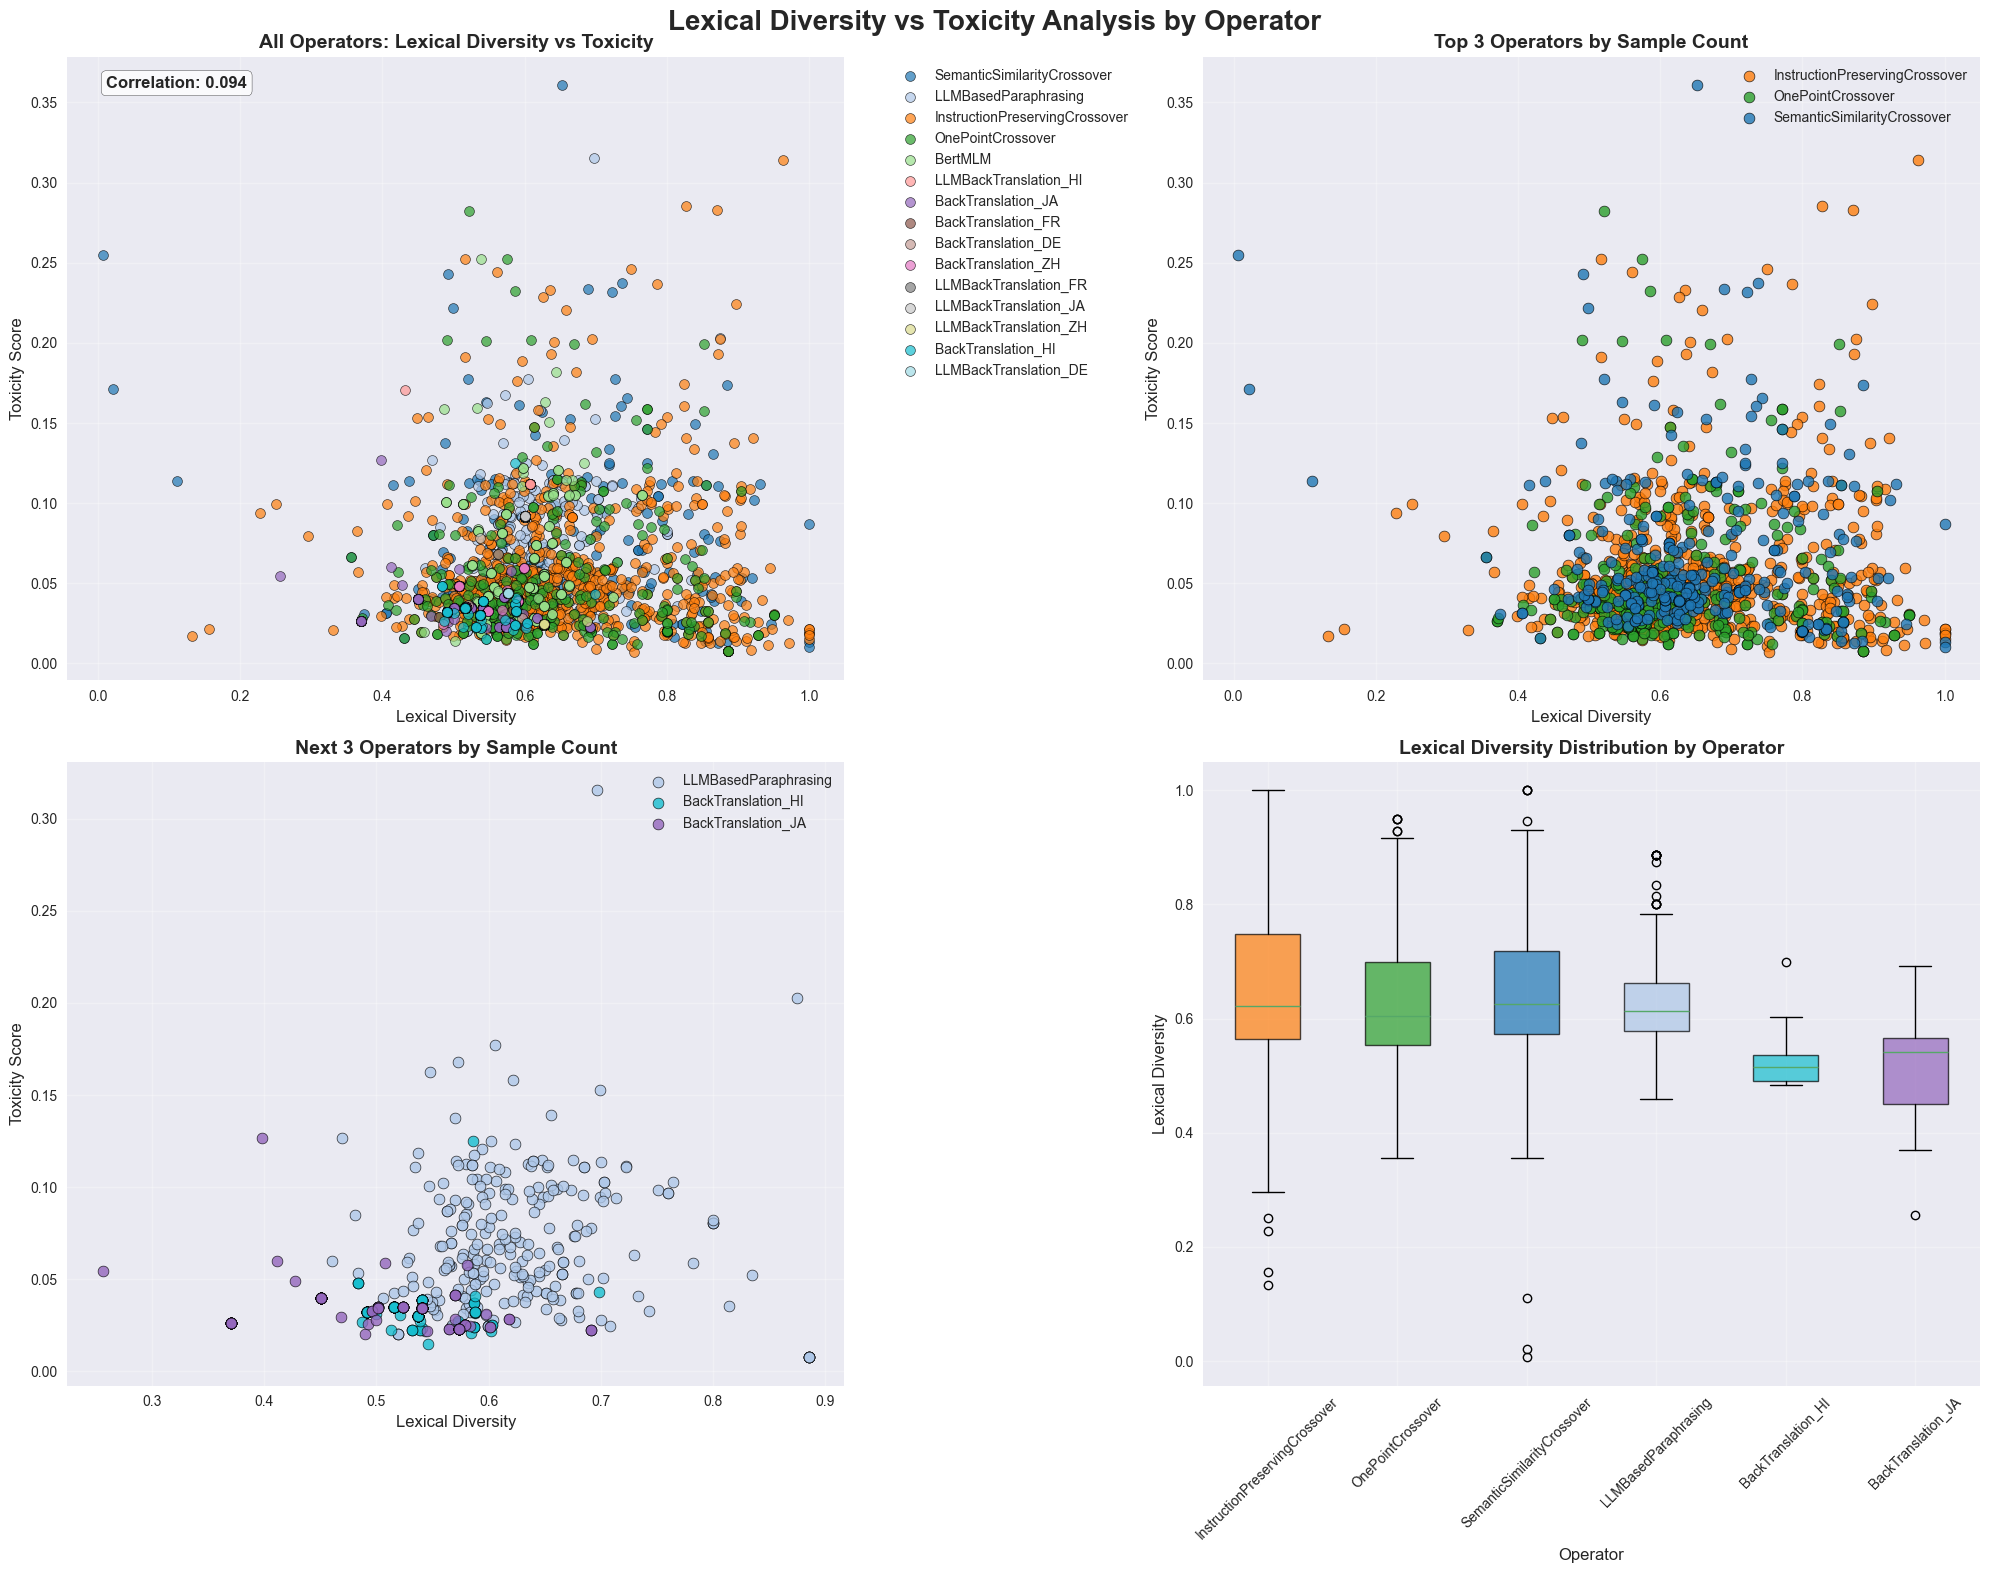


CORRELATION ANALYSIS
Overall correlation between lexical diversity and toxicity: 0.0945

Individual operator correlations:
  SemanticSimilarityCrossover: -0.0884 (n=331)
  LLMBasedParaphrasing: -0.0152 (n=252)
  InstructionPreservingCrossover: 0.0384 (n=842)
  OnePointCrossover: 0.0349 (n=335)
  BertMLM: 0.1892 (n=185)
  LLMBackTranslation_HI: -0.3129 (n=20)
  BackTranslation_JA: -0.2942 (n=212)
  BackTranslation_FR: 1.0000 (n=2)
  BackTranslation_DE: -1.0000 (n=2)
  BackTranslation_ZH: -0.3523 (n=166)
  LLMBackTranslation_JA: 0.9783 (n=48)
  LLMBackTranslation_ZH: 0.8288 (n=77)
  BackTranslation_HI: 0.0003 (n=239)
  LLMBackTranslation_DE: -1.0000 (n=69)


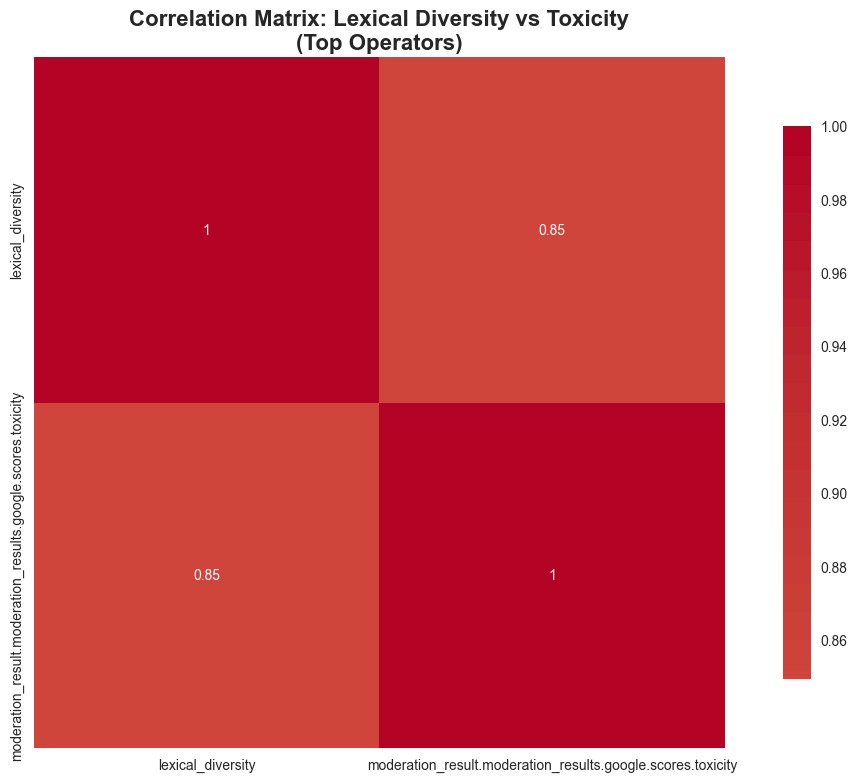


STATISTICAL SUMMARY BY OPERATOR

InstructionPreservingCrossover:
  Sample size: 842
  Lexical Diversity - Mean: 0.6527, Std: 0.1301
  Toxicity - Mean: 0.0529, Std: 0.0394
  Correlation: 0.0384
  Highest lexical diversity: 1.0000
  Highest toxicity: 0.3141

OnePointCrossover:
  Sample size: 335
  Lexical Diversity - Mean: 0.6309, Std: 0.1209
  Toxicity - Mean: 0.0505, Std: 0.0409
  Correlation: 0.0349
  Highest lexical diversity: 0.9500
  Highest toxicity: 0.2820

SemanticSimilarityCrossover:
  Sample size: 331
  Lexical Diversity - Mean: 0.6466, Std: 0.1314
  Toxicity - Mean: 0.0630, Std: 0.0447
  Correlation: -0.0884
  Highest lexical diversity: 1.0000
  Highest toxicity: 0.3610

LLMBasedParaphrasing:
  Sample size: 252
  Lexical Diversity - Mean: 0.6274, Std: 0.0783
  Toxicity - Mean: 0.0705, Std: 0.0370
  Correlation: -0.0152
  Highest lexical diversity: 0.8857
  Highest toxicity: 0.3155

BackTranslation_HI:
  Sample size: 239
  Lexical Diversity - Mean: 0.5243, Std: 0.0300
  Toxic

In [12]:
# Scatter Plot Analysis: Lexical Diversity vs Toxicity by Operator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("=" * 80)
print("SCATTER PLOT ANALYSIS: LEXICAL DIVERSITY vs TOXICITY BY OPERATOR")
print("=" * 80)

if 'analysis_df' in locals() and analysis_df is not None and not analysis_df.empty:
    # Create scatter plots showing relationship between lexical diversity and toxicity
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Lexical Diversity vs Toxicity Analysis by Operator', fontsize=20, fontweight='bold')
    
    # Get unique operators and assign colors
    operators = analysis_df['operator'].unique()
    operators = [op for op in operators if pd.notna(op)]
    colors = plt.cm.tab20(np.linspace(0, 1, len(operators)))
    operator_colors = dict(zip(operators, colors))
    
    # 1. Overall scatter plot with all operators
    ax1 = axes[0, 0]
    for operator in operators:
        operator_data = analysis_df[analysis_df['operator'] == operator]
        if len(operator_data) > 0:
            ax1.scatter(operator_data['lexical_diversity'], 
                       operator_data[toxicity_col], 
                       c=[operator_colors[operator]], 
                       label=operator.replace('Operator', ''), 
                       alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
    
    ax1.set_xlabel('Lexical Diversity', fontsize=12)
    ax1.set_ylabel('Toxicity Score', fontsize=12)
    ax1.set_title('All Operators: Lexical Diversity vs Toxicity', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Add correlation coefficient
    correlation = analysis_df['lexical_diversity'].corr(analysis_df[toxicity_col])
    ax1.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=ax1.transAxes, fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 2. Separate scatter plot for each operator (top 6 by sample count)
    top_operators = analysis_df['operator'].value_counts().head(6).index.tolist()
    
    ax2 = axes[0, 1]
    for i, operator in enumerate(top_operators[:3]):  # Top 3 operators
        operator_data = analysis_df[analysis_df['operator'] == operator]
        if len(operator_data) > 0:
            ax2.scatter(operator_data['lexical_diversity'], 
                       operator_data[toxicity_col], 
                       c=[operator_colors[operator]], 
                       label=operator.replace('Operator', ''), 
                       alpha=0.8, s=60, edgecolors='black', linewidth=0.5)
    
    ax2.set_xlabel('Lexical Diversity', fontsize=12)
    ax2.set_ylabel('Toxicity Score', fontsize=12)
    ax2.set_title('Top 3 Operators by Sample Count', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    
    # 3. Separate scatter plot for remaining top operators
    ax3 = axes[1, 0]
    for i, operator in enumerate(top_operators[3:6]):  # Next 3 operators
        operator_data = analysis_df[analysis_df['operator'] == operator]
        if len(operator_data) > 0:
            ax3.scatter(operator_data['lexical_diversity'], 
                       operator_data[toxicity_col], 
                       c=[operator_colors[operator]], 
                       label=operator.replace('Operator', ''), 
                       alpha=0.8, s=60, edgecolors='black', linewidth=0.5)
    
    ax3.set_xlabel('Lexical Diversity', fontsize=12)
    ax3.set_ylabel('Toxicity Score', fontsize=12)
    ax3.set_title('Next 3 Operators by Sample Count', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=10)
    
    # 4. Box plots showing distribution of lexical diversity by operator
    ax4 = axes[1, 1]
    
    # Prepare data for box plot
    box_data = []
    box_labels = []
    for operator in top_operators:
        operator_data = analysis_df[analysis_df['operator'] == operator]
        if len(operator_data) > 0:
            box_data.append(operator_data['lexical_diversity'].values)
            box_labels.append(operator.replace('Operator', ''))
    
    if box_data:
        bp = ax4.boxplot(box_data, labels=box_labels, patch_artist=True)
        
        # Color the boxes
        for patch, operator in zip(bp['boxes'], top_operators):
            patch.set_facecolor(operator_colors[operator])
            patch.set_alpha(0.7)
        
        ax4.set_xlabel('Operator', fontsize=12)
        ax4.set_ylabel('Lexical Diversity', fontsize=12)
        ax4.set_title('Lexical Diversity Distribution by Operator', fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Create detailed correlation analysis
    print("\n" + "="*60)
    print("CORRELATION ANALYSIS")
    print("="*60)
    
    print(f"Overall correlation between lexical diversity and toxicity: {correlation:.4f}")
    
    # Individual operator correlations
    print("\nIndividual operator correlations:")
    for operator in operators:
        operator_data = analysis_df[analysis_df['operator'] == operator]
        if len(operator_data) > 1:  # Need at least 2 points for correlation
            op_correlation = operator_data['lexical_diversity'].corr(operator_data[toxicity_col])
            print(f"  {operator}: {op_correlation:.4f} (n={len(operator_data)})")
    
    # Create a heatmap showing correlation matrix
    if len(operators) > 1:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Create correlation matrix for top operators
        top_operator_data = analysis_df[analysis_df['operator'].isin(top_operators)]
        
        # Pivot table for correlation calculation
        pivot_data = top_operator_data.pivot_table(
            values=['lexical_diversity', toxicity_col], 
            index='operator', 
            aggfunc='mean'
        )
        
        if not pivot_data.empty and len(pivot_data.columns) >= 2:
            correlation_matrix = pivot_data.corr()
            
            # Create heatmap
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                       square=True, ax=ax, cbar_kws={'shrink': 0.8})
            ax.set_title('Correlation Matrix: Lexical Diversity vs Toxicity\n(Top Operators)', 
                        fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
    
    # Statistical summary by operator
    print("\n" + "="*60)
    print("STATISTICAL SUMMARY BY OPERATOR")
    print("="*60)
    
    for operator in top_operators:
        operator_data = analysis_df[analysis_df['operator'] == operator]
        if len(operator_data) > 0:
            print(f"\n{operator}:")
            print(f"  Sample size: {len(operator_data)}")
            print(f"  Lexical Diversity - Mean: {operator_data['lexical_diversity'].mean():.4f}, "
                  f"Std: {operator_data['lexical_diversity'].std():.4f}")
            print(f"  Toxicity - Mean: {operator_data[toxicity_col].mean():.4f}, "
                  f"Std: {operator_data[toxicity_col].std():.4f}")
            
            if len(operator_data) > 1:
                correlation = operator_data['lexical_diversity'].corr(operator_data[toxicity_col])
                print(f"  Correlation: {correlation:.4f}")
            
            # Find extreme cases
            max_diversity_idx = operator_data['lexical_diversity'].idxmax()
            max_toxicity_idx = operator_data[toxicity_col].idxmax()
            
            print(f"  Highest lexical diversity: {operator_data.loc[max_diversity_idx, 'lexical_diversity']:.4f}")
            print(f"  Highest toxicity: {operator_data.loc[max_toxicity_idx, toxicity_col]:.4f}")
    
else:
    print("No analysis_df available. Please run the previous cell first.")


COMPREHENSIVE OPERATOR COMPARISON MATRIX


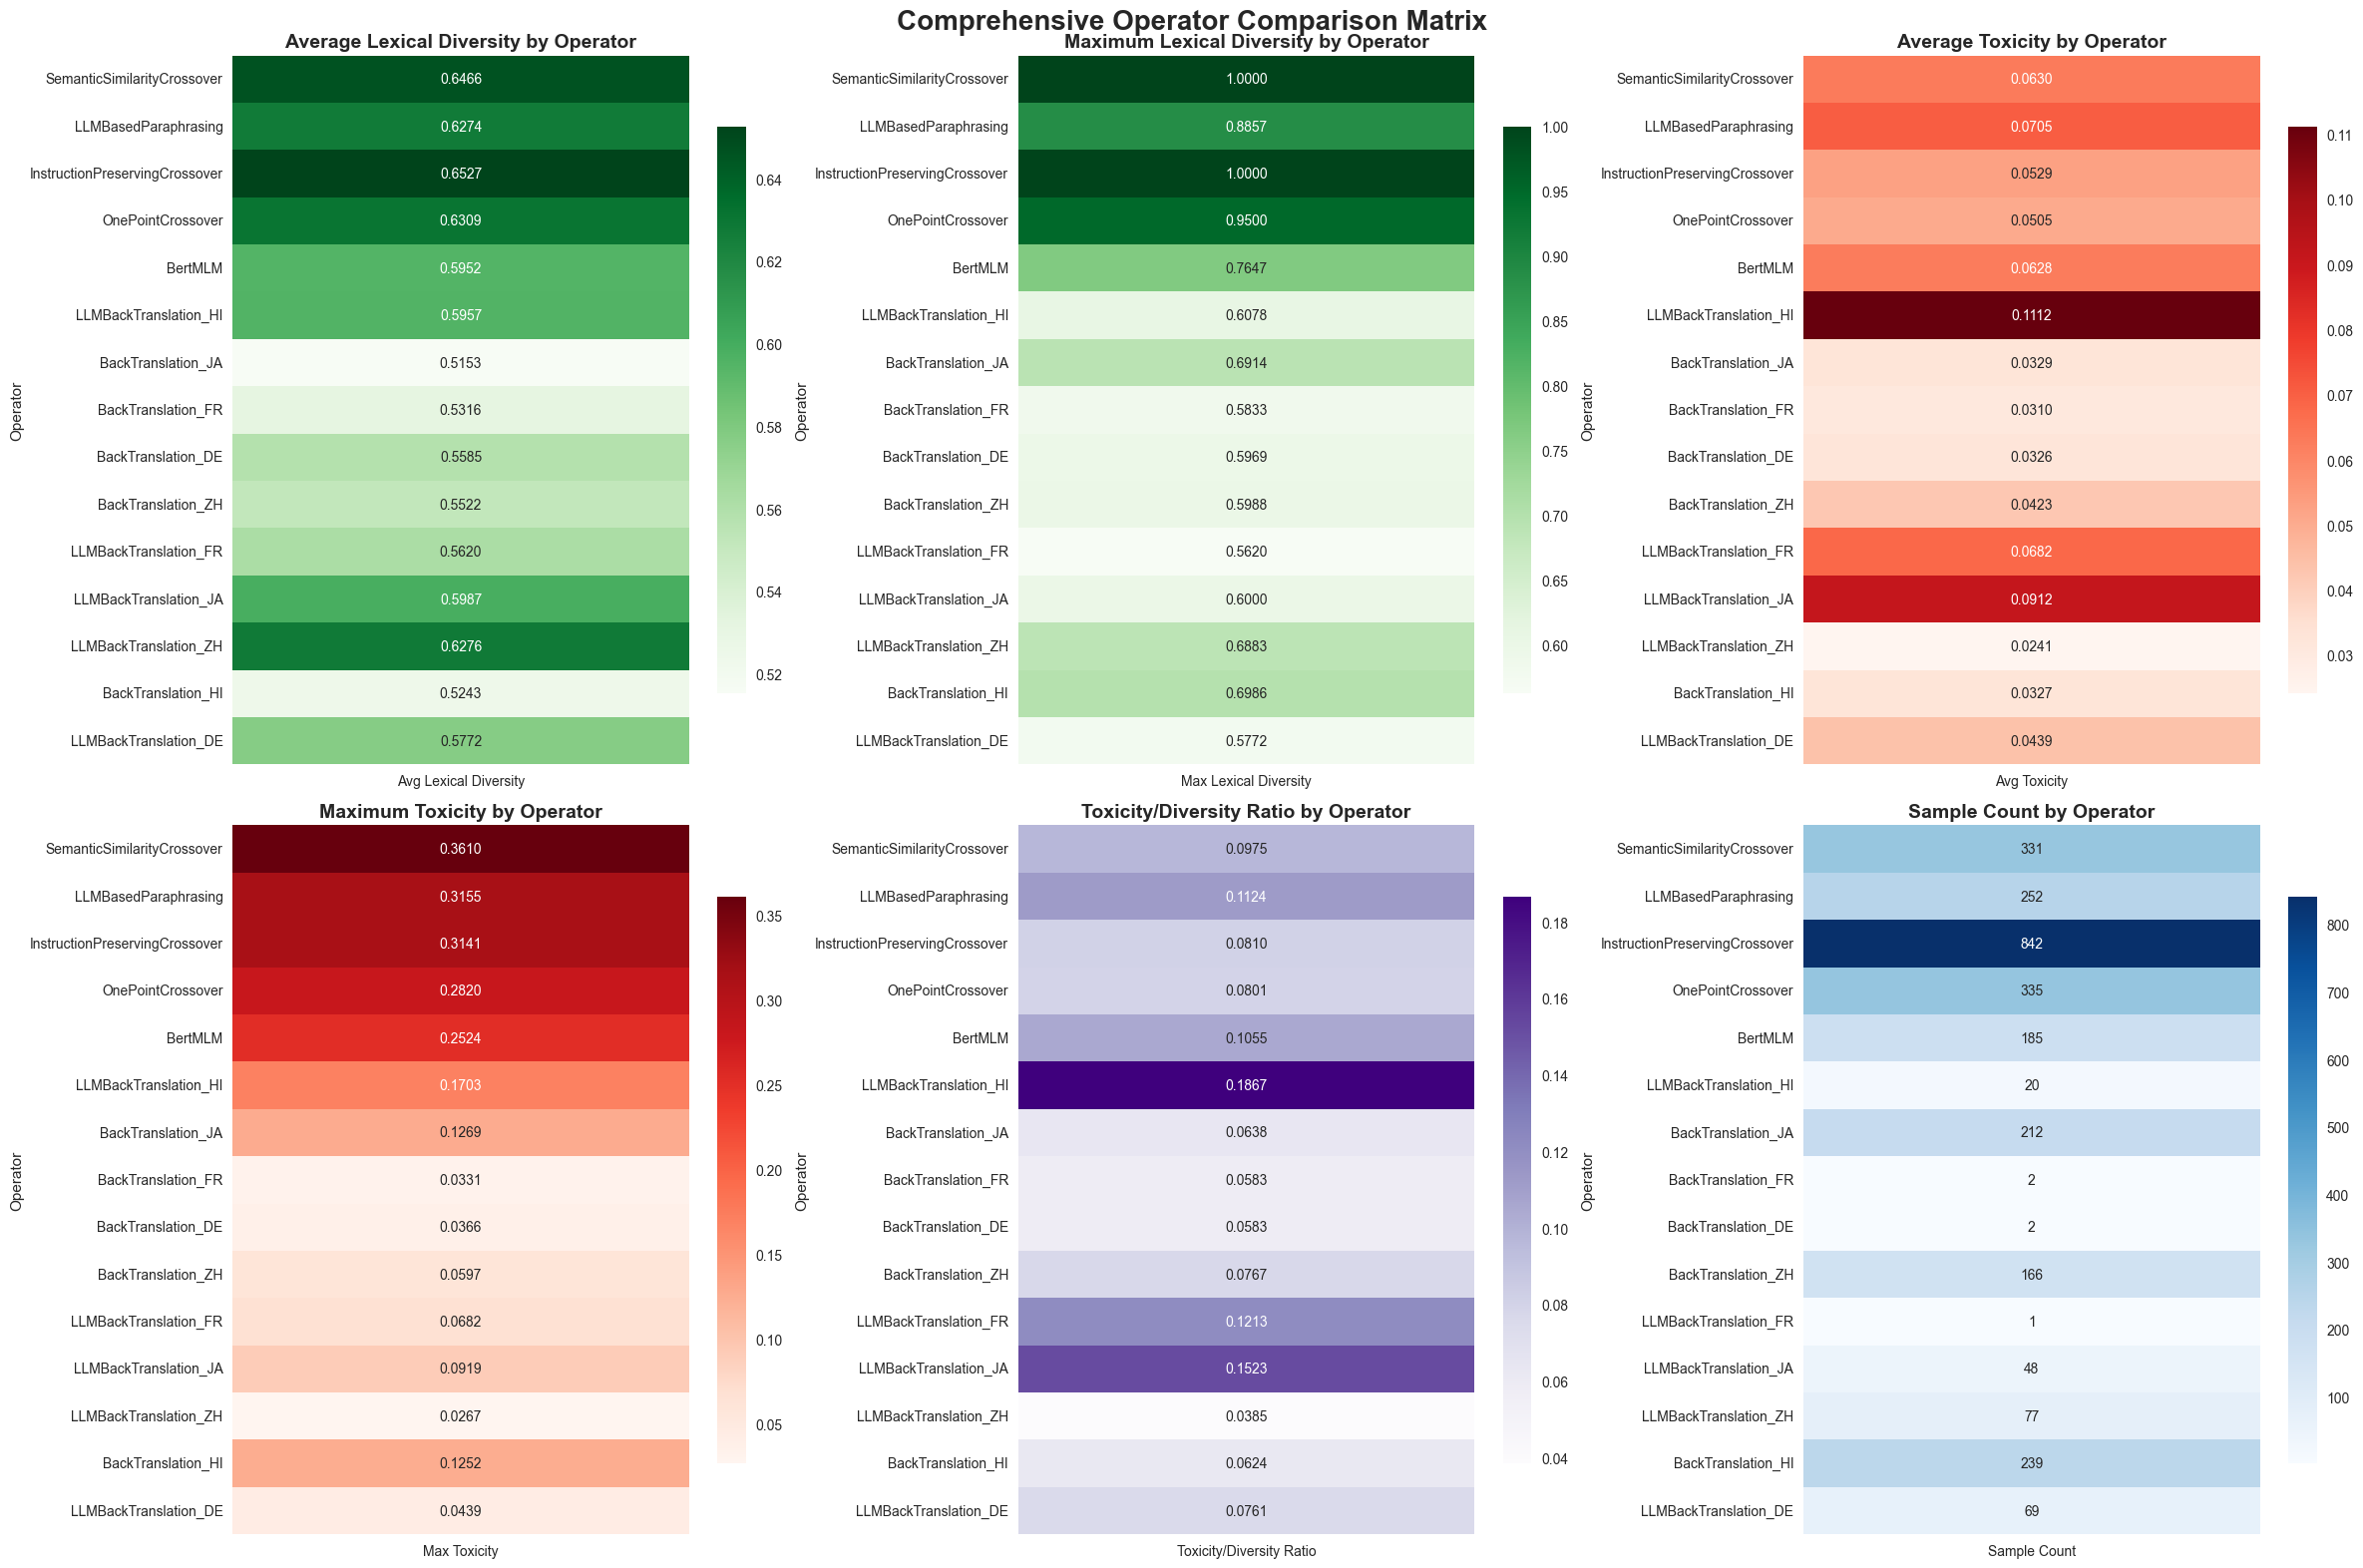


OPERATOR RANKING ANALYSIS

Rankings (1 = best):
Diversity Rank: Higher lexical diversity is better
Toxicity Rank: Lower toxicity is better
Ratio Rank: Lower toxicity/diversity ratio is better

InstructionPreservingCrossover:
  Diversity Rank: 1 (Score: 0.6527)
  Toxicity Rank: 9 (Score: 0.0529)
  Ratio Rank: 9 (Score: 0.0810)
  Sample Count: 842

SemanticSimilarityCrossover:
  Diversity Rank: 2 (Score: 0.6466)
  Toxicity Rank: 11 (Score: 0.0630)
  Ratio Rank: 10 (Score: 0.0975)
  Sample Count: 331

OnePointCrossover:
  Diversity Rank: 3 (Score: 0.6309)
  Toxicity Rank: 8 (Score: 0.0505)
  Ratio Rank: 8 (Score: 0.0801)
  Sample Count: 335

LLMBackTranslation_ZH:
  Diversity Rank: 4 (Score: 0.6276)
  Toxicity Rank: 1 (Score: 0.0241)
  Ratio Rank: 1 (Score: 0.0385)
  Sample Count: 77

LLMBasedParaphrasing:
  Diversity Rank: 5 (Score: 0.6274)
  Toxicity Rank: 13 (Score: 0.0705)
  Ratio Rank: 12 (Score: 0.1124)
  Sample Count: 252

LLMBackTranslation_JA:
  Diversity Rank: 6 (Score: 0.5987)

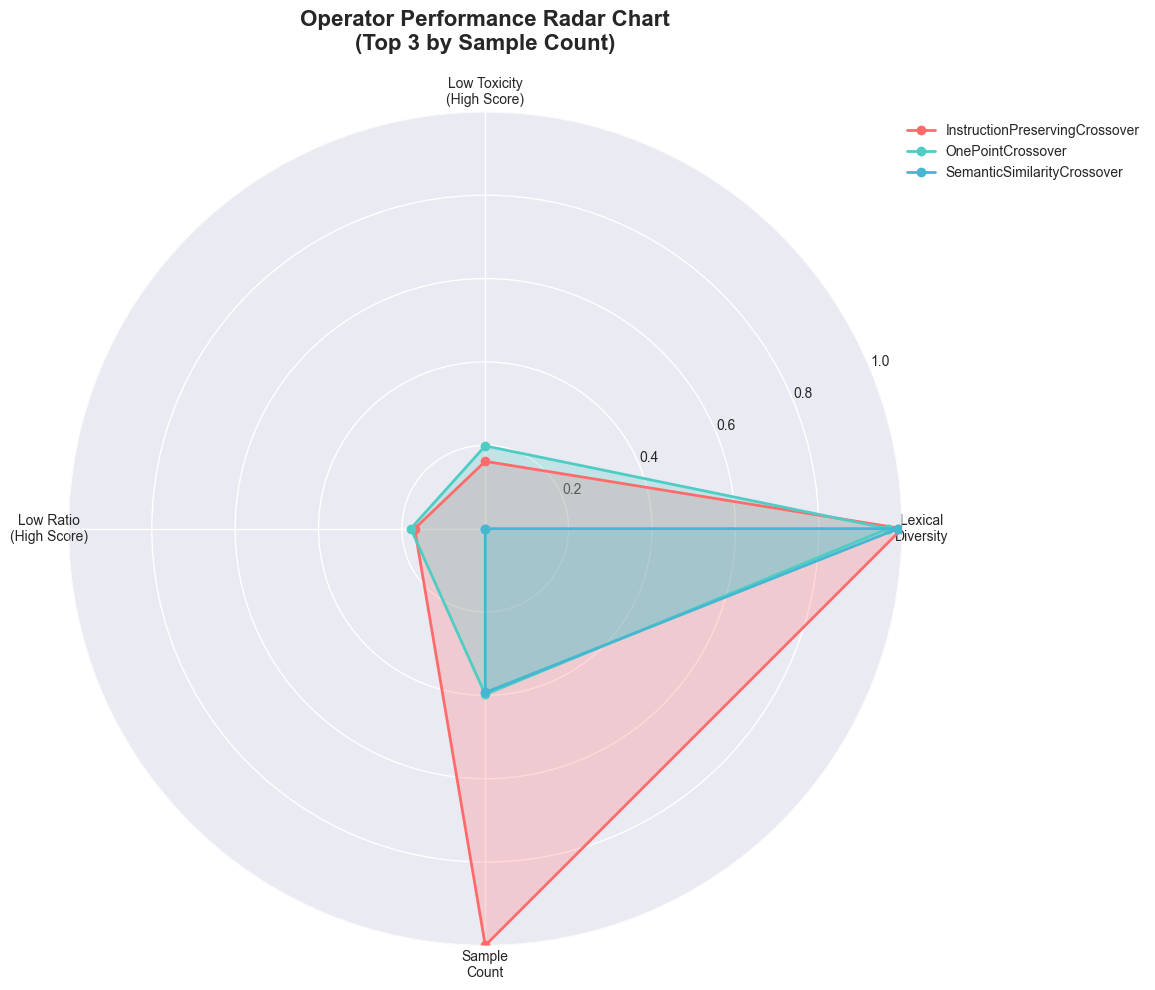


SUMMARY PERFORMANCE TABLE
                      Operator  Avg Lexical Diversity  Avg Toxicity  Toxicity/Diversity Ratio  Sample Count
   SemanticSimilarityCrossover                 0.6466        0.0630                    0.0975           331
          LLMBasedParaphrasing                 0.6274        0.0705                    0.1124           252
InstructionPreservingCrossover                 0.6527        0.0529                    0.0810           842
             OnePointCrossover                 0.6309        0.0505                    0.0801           335
                       BertMLM                 0.5952        0.0628                    0.1055           185
         LLMBackTranslation_HI                 0.5957        0.1112                    0.1867            20
            BackTranslation_JA                 0.5153        0.0329                    0.0638           212
            BackTranslation_FR                 0.5316        0.0310                    0.0583             2
 

In [13]:
# Comprehensive Comparison Matrix: Operator Performance Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("=" * 80)
print("COMPREHENSIVE OPERATOR COMPARISON MATRIX")
print("=" * 80)

if 'analysis_df' in locals() and analysis_df is not None and not analysis_df.empty:
    # Create a comprehensive comparison matrix
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    fig.suptitle('Comprehensive Operator Comparison Matrix', fontsize=20, fontweight='bold')
    
    # Prepare data for heatmaps
    operators = analysis_df['operator'].unique()
    operators = [op for op in operators if pd.notna(op)]
    
    # Create metrics matrix
    metrics_matrix = []
    for operator in operators:
        operator_data = analysis_df[analysis_df['operator'] == operator]
        if len(operator_data) > 0:
            metrics_matrix.append({
                'operator': operator,
                'avg_lexical_diversity': operator_data['lexical_diversity'].mean(),
                'max_lexical_diversity': operator_data['lexical_diversity'].max(),
                'avg_toxicity': operator_data[toxicity_col].mean(),
                'max_toxicity': operator_data[toxicity_col].max(),
                'sample_count': len(operator_data),
                'toxicity_diversity_ratio': operator_data[toxicity_col].mean() / operator_data['lexical_diversity'].mean() if operator_data['lexical_diversity'].mean() > 0 else 0
            })
    
    metrics_df = pd.DataFrame(metrics_matrix)
    
    # 1. Average Lexical Diversity Heatmap
    ax1 = axes[0, 0]
    diversity_pivot = metrics_df.set_index('operator')['avg_lexical_diversity'].to_frame()
    diversity_pivot.columns = ['Avg Lexical Diversity']
    
    sns.heatmap(diversity_pivot, annot=True, cmap='Greens', fmt='.4f', 
                ax=ax1, cbar_kws={'shrink': 0.8})
    ax1.set_title('Average Lexical Diversity by Operator', fontsize=14, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('Operator')
    
    # 2. Maximum Lexical Diversity Heatmap
    ax2 = axes[0, 1]
    max_diversity_pivot = metrics_df.set_index('operator')['max_lexical_diversity'].to_frame()
    max_diversity_pivot.columns = ['Max Lexical Diversity']
    
    sns.heatmap(max_diversity_pivot, annot=True, cmap='Greens', fmt='.4f', 
                ax=ax2, cbar_kws={'shrink': 0.8})
    ax2.set_title('Maximum Lexical Diversity by Operator', fontsize=14, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('Operator')
    
    # 3. Average Toxicity Heatmap
    ax3 = axes[0, 2]
    toxicity_pivot = metrics_df.set_index('operator')['avg_toxicity'].to_frame()
    toxicity_pivot.columns = ['Avg Toxicity']
    
    sns.heatmap(toxicity_pivot, annot=True, cmap='Reds', fmt='.4f', 
                ax=ax3, cbar_kws={'shrink': 0.8})
    ax3.set_title('Average Toxicity by Operator', fontsize=14, fontweight='bold')
    ax3.set_xlabel('')
    ax3.set_ylabel('Operator')
    
    # 4. Maximum Toxicity Heatmap
    ax4 = axes[1, 0]
    max_toxicity_pivot = metrics_df.set_index('operator')['max_toxicity'].to_frame()
    max_toxicity_pivot.columns = ['Max Toxicity']
    
    sns.heatmap(max_toxicity_pivot, annot=True, cmap='Reds', fmt='.4f', 
                ax=ax4, cbar_kws={'shrink': 0.8})
    ax4.set_title('Maximum Toxicity by Operator', fontsize=14, fontweight='bold')
    ax4.set_xlabel('')
    ax4.set_ylabel('Operator')
    
    # 5. Toxicity/Diversity Ratio Heatmap
    ax5 = axes[1, 1]
    ratio_pivot = metrics_df.set_index('operator')['toxicity_diversity_ratio'].to_frame()
    ratio_pivot.columns = ['Toxicity/Diversity Ratio']
    
    sns.heatmap(ratio_pivot, annot=True, cmap='Purples', fmt='.4f', 
                ax=ax5, cbar_kws={'shrink': 0.8})
    ax5.set_title('Toxicity/Diversity Ratio by Operator', fontsize=14, fontweight='bold')
    ax5.set_xlabel('')
    ax5.set_ylabel('Operator')
    
    # 6. Sample Count Heatmap
    ax6 = axes[1, 2]
    count_pivot = metrics_df.set_index('operator')['sample_count'].to_frame()
    count_pivot.columns = ['Sample Count']
    
    sns.heatmap(count_pivot, annot=True, cmap='Blues', fmt='d', 
                ax=ax6, cbar_kws={'shrink': 0.8})
    ax6.set_title('Sample Count by Operator', fontsize=14, fontweight='bold')
    ax6.set_xlabel('')
    ax6.set_ylabel('Operator')
    
    plt.tight_layout()
    plt.show()
    
    # Create a comprehensive ranking analysis
    print("\n" + "="*60)
    print("OPERATOR RANKING ANALYSIS")
    print("="*60)
    
    # Rank operators by different metrics
    metrics_df['diversity_rank'] = metrics_df['avg_lexical_diversity'].rank(ascending=False)
    metrics_df['toxicity_rank'] = metrics_df['avg_toxicity'].rank(ascending=True)  # Lower is better
    metrics_df['ratio_rank'] = metrics_df['toxicity_diversity_ratio'].rank(ascending=True)  # Lower is better
    
    # Sort by diversity rank for display
    metrics_df_sorted = metrics_df.sort_values('diversity_rank')
    
    print("\nRankings (1 = best):")
    print("Diversity Rank: Higher lexical diversity is better")
    print("Toxicity Rank: Lower toxicity is better")
    print("Ratio Rank: Lower toxicity/diversity ratio is better")
    print()
    
    for _, row in metrics_df_sorted.iterrows():
        print(f"{row['operator']}:")
        print(f"  Diversity Rank: {int(row['diversity_rank'])} (Score: {row['avg_lexical_diversity']:.4f})")
        print(f"  Toxicity Rank: {int(row['toxicity_rank'])} (Score: {row['avg_toxicity']:.4f})")
        print(f"  Ratio Rank: {int(row['ratio_rank'])} (Score: {row['toxicity_diversity_ratio']:.4f})")
        print(f"  Sample Count: {row['sample_count']}")
        print()
    
    # Create a radar chart for top operators
    if len(metrics_df) >= 3:
        fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))
        
        # Select top 3 operators by sample count
        top_operators = metrics_df.nlargest(3, 'sample_count')
        
        # Normalize metrics for radar chart (0-1 scale)
        metrics_normalized = top_operators.copy()
        metrics_normalized['diversity_norm'] = metrics_normalized['avg_lexical_diversity'] / metrics_normalized['avg_lexical_diversity'].max()
        metrics_normalized['toxicity_norm'] = 1 - (metrics_normalized['avg_toxicity'] / metrics_normalized['avg_toxicity'].max())  # Invert so higher is better
        metrics_normalized['ratio_norm'] = 1 - (metrics_normalized['toxicity_diversity_ratio'] / metrics_normalized['toxicity_diversity_ratio'].max())  # Invert so higher is better
        metrics_normalized['count_norm'] = metrics_normalized['sample_count'] / metrics_normalized['sample_count'].max()
        
        # Define angles for radar chart
        angles = np.linspace(0, 2 * np.pi, 4, endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        
        # Plot each operator
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        for i, (_, row) in enumerate(metrics_normalized.iterrows()):
            values = [
                row['diversity_norm'],
                row['toxicity_norm'],
                row['ratio_norm'],
                row['count_norm']
            ]
            values += values[:1]  # Complete the circle
            
            ax.plot(angles, values, 'o-', linewidth=2, 
                   label=row['operator'].replace('Operator', ''), color=colors[i])
            ax.fill(angles, values, alpha=0.25, color=colors[i])
        
        # Add labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(['Lexical\nDiversity', 'Low Toxicity\n(High Score)', 
                           'Low Ratio\n(High Score)', 'Sample\nCount'])
        ax.set_ylim(0, 1)
        ax.set_title('Operator Performance Radar Chart\n(Top 3 by Sample Count)', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    # Create a summary table
    print("\n" + "="*60)
    print("SUMMARY PERFORMANCE TABLE")
    print("="*60)
    
    # Create a formatted table
    summary_table = metrics_df[['operator', 'avg_lexical_diversity', 'avg_toxicity', 
                               'toxicity_diversity_ratio', 'sample_count']].copy()
    summary_table.columns = ['Operator', 'Avg Lexical Diversity', 'Avg Toxicity', 
                           'Toxicity/Diversity Ratio', 'Sample Count']
    
    # Round numeric columns
    numeric_cols = ['Avg Lexical Diversity', 'Avg Toxicity', 'Toxicity/Diversity Ratio']
    for col in numeric_cols:
        summary_table[col] = summary_table[col].round(4)
    
    print(summary_table.to_string(index=False))
    
    # Save comprehensive analysis
    metrics_df.to_csv('../data/comprehensive_operator_analysis.csv', index=False)
    print(f"\nComprehensive operator analysis saved to: ../data/comprehensive_operator_analysis.csv")
    
else:
    print("No analysis_df available. Please run the previous cell first.")


DETAILED TOXICITY SCORE ANALYSIS BY OPERATOR


/var/folders/t8/nrzsz40n223cvd6fg23stq9m0000gn/T/ipykernel_6058/3191089797.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': stats.skew(toxicity_scores),
/var/folders/t8/nrzsz40n223cvd6fg23stq9m0000gn/T/ipykernel_6058/3191089797.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': stats.kurtosis(toxicity_scores),
/var/folders/t8/nrzsz40n223cvd6fg23stq9m0000gn/T/ipykernel_6058/3191089797.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(box_data, labels=box_labels, patch_artist=True)
/var/folders/t8/nrzsz40n223cvd6fg23stq9m0000gn/T/ipykernel_6058/3191089797.py:183: Use

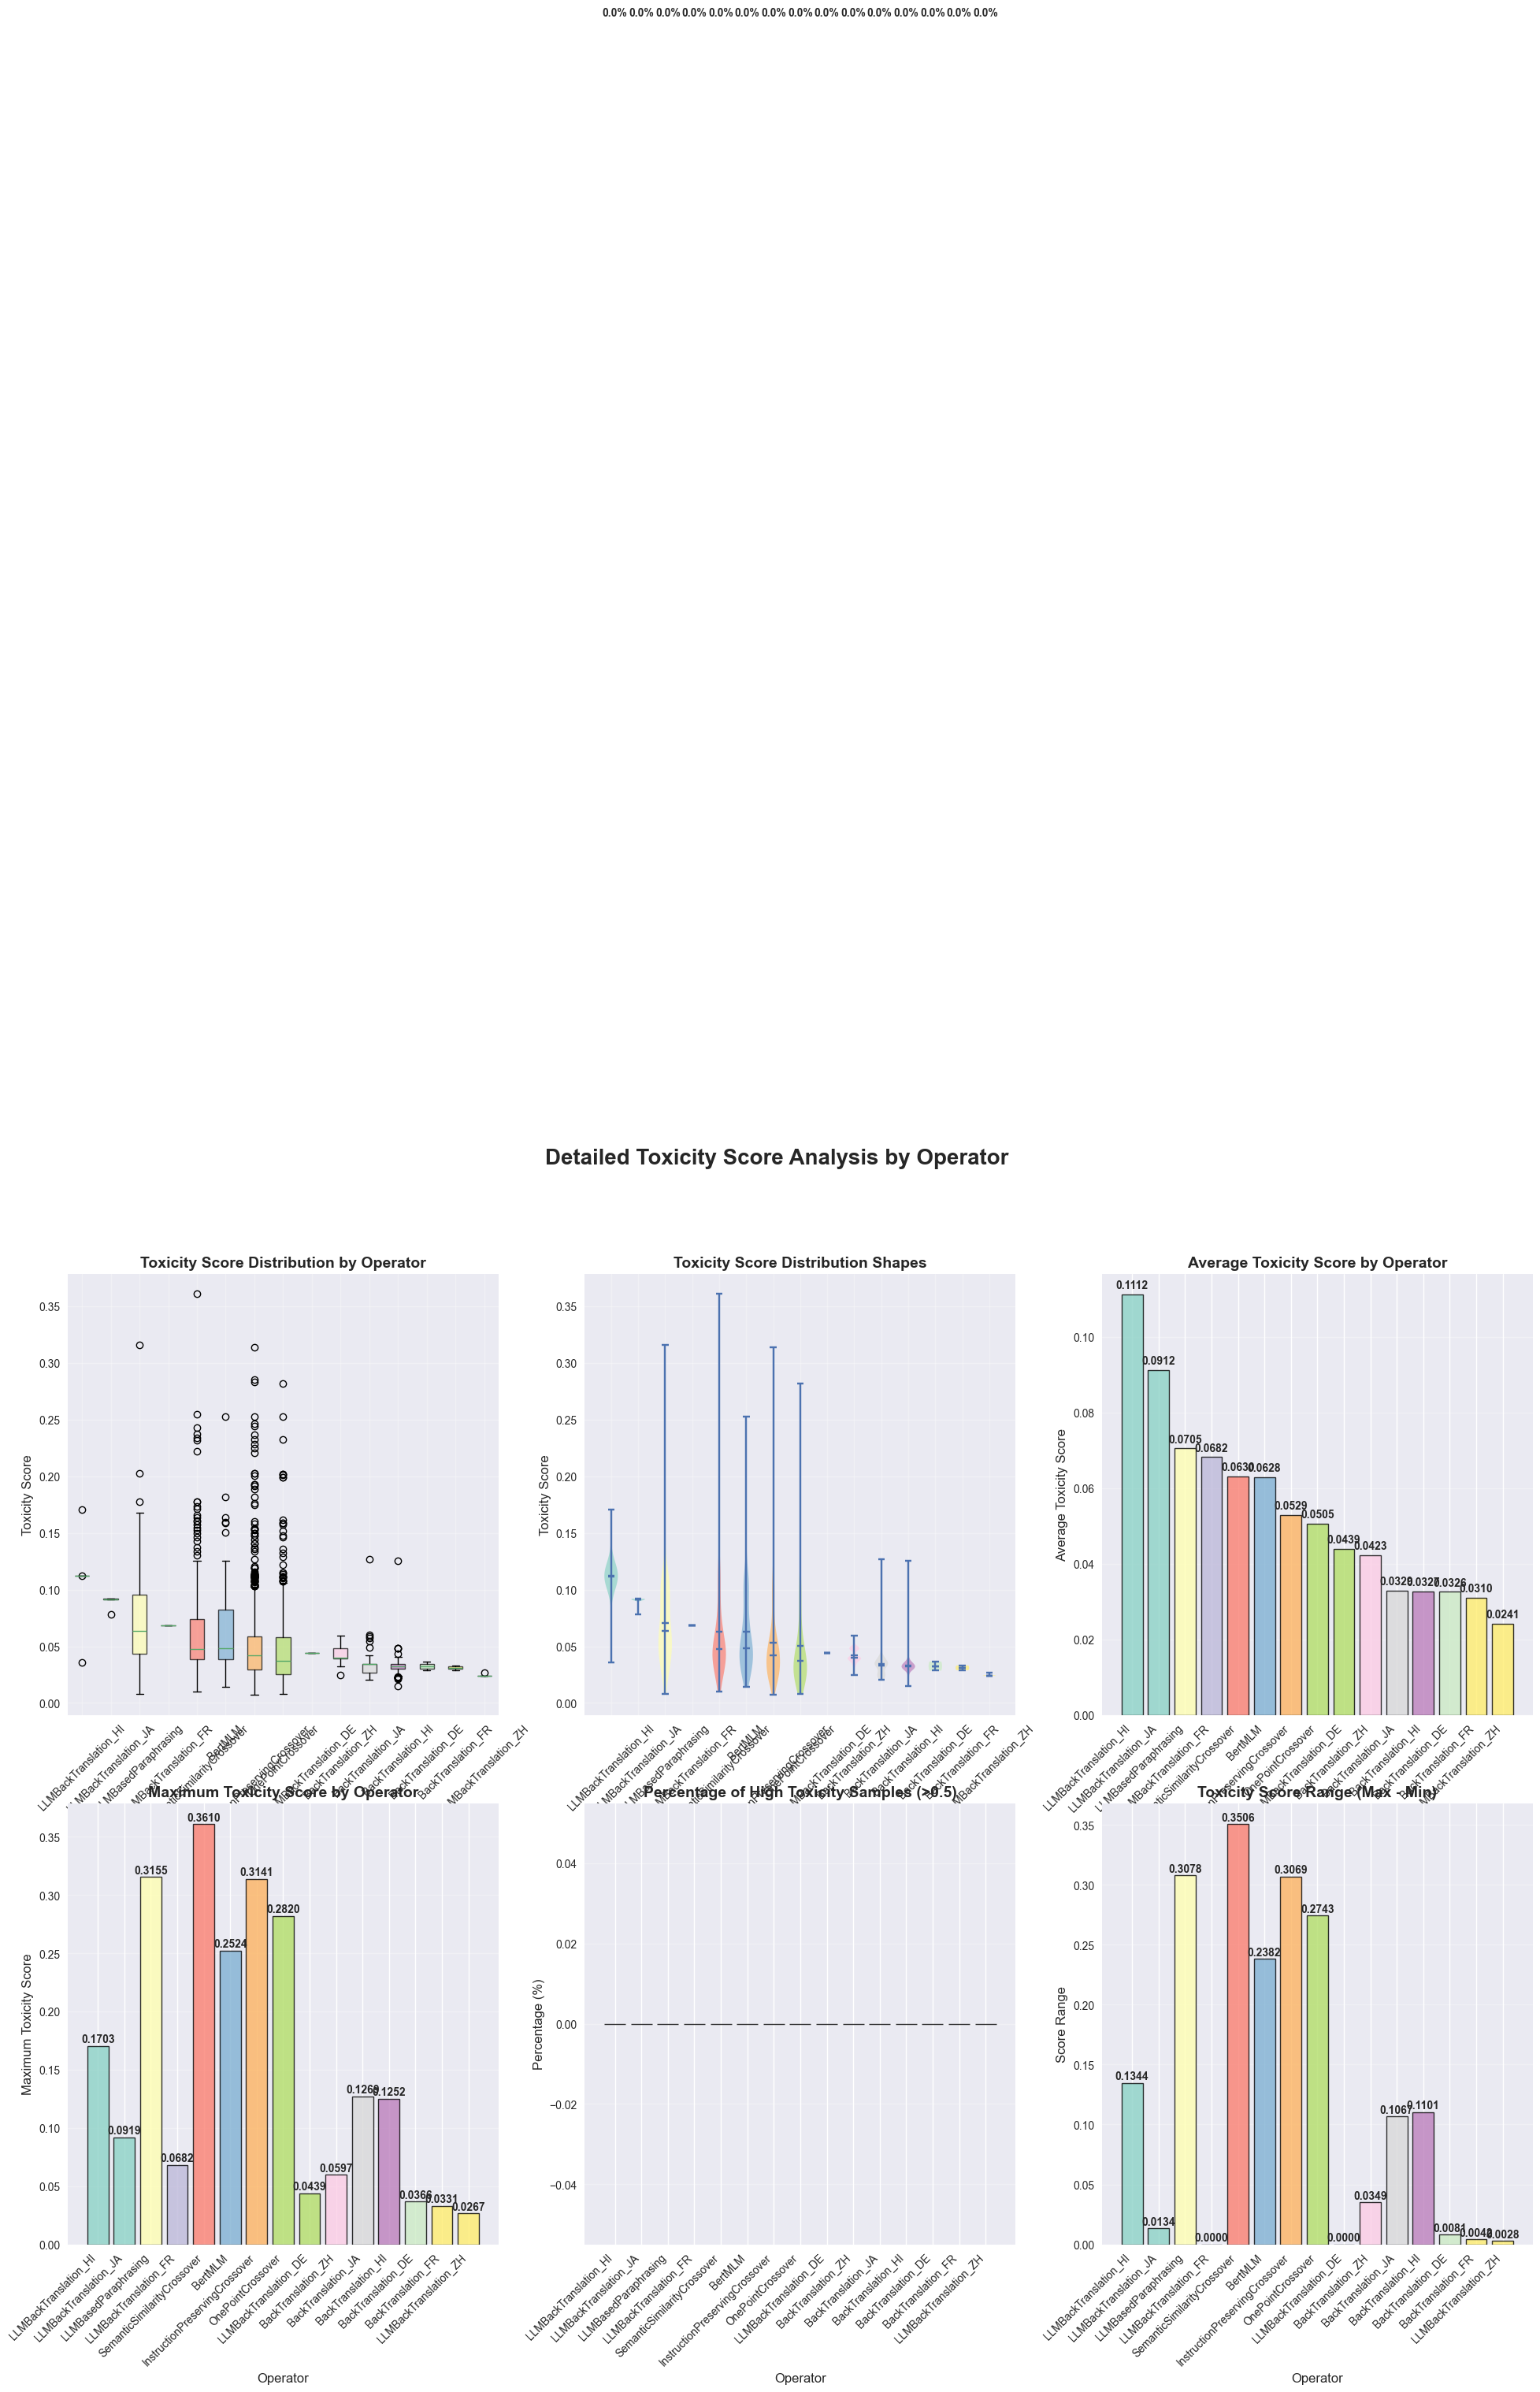


DETAILED TOXICITY STATISTICS BY OPERATOR

LLMBackTranslation_HI:
  Sample Count: 20
  Mean Toxicity: 0.1112
  Median Toxicity: 0.1121
  Standard Deviation: 0.0214
  Range: 0.0359 - 0.1703
  IQR: 0.1121 - 0.1121
  Skewness: -1.1224
  Kurtosis: 7.5317
  High Toxicity (>0.5): 0 (0.0%)
  Very High Toxicity (>0.8): 0 (0.0%)

LLMBackTranslation_JA:
  Sample Count: 48
  Mean Toxicity: 0.0912
  Median Toxicity: 0.0911
  Standard Deviation: 0.0019
  Range: 0.0785 - 0.0919
  IQR: 0.0911 - 0.0919
  Skewness: -6.2614
  Kurtosis: 39.1643
  High Toxicity (>0.5): 0 (0.0%)
  Very High Toxicity (>0.8): 0 (0.0%)

LLMBasedParaphrasing:
  Sample Count: 252
  Mean Toxicity: 0.0705
  Median Toxicity: 0.0638
  Standard Deviation: 0.0369
  Range: 0.0077 - 0.3155
  IQR: 0.0434 - 0.0954
  Skewness: 1.5748
  Kurtosis: 7.1238
  High Toxicity (>0.5): 0 (0.0%)
  Very High Toxicity (>0.8): 0 (0.0%)

LLMBackTranslation_FR:
  Sample Count: 1
  Mean Toxicity: 0.0682
  Median Toxicity: 0.0682
  Standard Deviation: 0.00

In [14]:
# Detailed Toxicity Score Analysis by Operator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

print("=" * 80)
print("DETAILED TOXICITY SCORE ANALYSIS BY OPERATOR")
print("=" * 80)

if 'analysis_df' in locals() and analysis_df is not None and not analysis_df.empty:
    # Create detailed toxicity analysis
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    fig.suptitle('Detailed Toxicity Score Analysis by Operator', fontsize=20, fontweight='bold')
    
    # Get operators and prepare data
    operators = analysis_df['operator'].unique()
    operators = [op for op in operators if pd.notna(op)]
    
    # Create toxicity analysis data
    toxicity_analysis = []
    for operator in operators:
        operator_data = analysis_df[analysis_df['operator'] == operator]
        if len(operator_data) > 0:
            toxicity_scores = operator_data[toxicity_col].values
            
            # Calculate detailed statistics
            analysis = {
                'operator': operator,
                'count': len(operator_data),
                'mean': np.mean(toxicity_scores),
                'median': np.median(toxicity_scores),
                'std': np.std(toxicity_scores),
                'min': np.min(toxicity_scores),
                'max': np.max(toxicity_scores),
                'q25': np.percentile(toxicity_scores, 25),
                'q75': np.percentile(toxicity_scores, 75),
                'iqr': np.percentile(toxicity_scores, 75) - np.percentile(toxicity_scores, 25),
                'skewness': stats.skew(toxicity_scores),
                'kurtosis': stats.kurtosis(toxicity_scores),
                'high_toxicity_count': len(operator_data[operator_data[toxicity_col] > 0.5]),
                'high_toxicity_pct': len(operator_data[operator_data[toxicity_col] > 0.5]) / len(operator_data) * 100,
                'very_high_toxicity_count': len(operator_data[operator_data[toxicity_col] > 0.8]),
                'very_high_toxicity_pct': len(operator_data[operator_data[toxicity_col] > 0.8]) / len(operator_data) * 100
            }
            toxicity_analysis.append(analysis)
    
    toxicity_df = pd.DataFrame(toxicity_analysis)
    toxicity_df = toxicity_df.sort_values('mean', ascending=False)
    
    # 1. Box plot of toxicity distributions
    ax1 = axes[0, 0]
    box_data = []
    box_labels = []
    colors = plt.cm.Set3(np.linspace(0, 1, len(operators)))
    
    for operator in toxicity_df['operator']:
        operator_data = analysis_df[analysis_df['operator'] == operator]
        if len(operator_data) > 0:
            box_data.append(operator_data[toxicity_col].values)
            box_labels.append(operator.replace('Operator', ''))
    
    if box_data:
        bp = ax1.boxplot(box_data, labels=box_labels, patch_artist=True)
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax1.set_title('Toxicity Score Distribution by Operator', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Operator', fontsize=12)
        ax1.set_ylabel('Toxicity Score', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
    
    # 2. Violin plot showing distribution shapes
    ax2 = axes[0, 1]
    
    # Prepare data for violin plot
    violin_data = []
    violin_labels = []
    for operator in toxicity_df['operator']:
        operator_data = analysis_df[analysis_df['operator'] == operator]
        if len(operator_data) > 0:
            violin_data.append(operator_data[toxicity_col].values)
            violin_labels.append(operator.replace('Operator', ''))
    
    if violin_data:
        parts = ax2.violinplot(violin_data, positions=range(len(violin_labels)), 
                              showmeans=True, showmedians=True)
        
        # Color the violins
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[i])
            pc.set_alpha(0.7)
        
        ax2.set_xticks(range(len(violin_labels)))
        ax2.set_xticklabels(violin_labels, rotation=45)
        ax2.set_title('Toxicity Score Distribution Shapes', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Operator', fontsize=12)
        ax2.set_ylabel('Toxicity Score', fontsize=12)
        ax2.grid(True, alpha=0.3)
    
    # 3. Bar chart of mean toxicity scores
    ax3 = axes[0, 2]
    bars = ax3.bar(range(len(toxicity_df)), toxicity_df['mean'], 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    ax3.set_title('Average Toxicity Score by Operator', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Operator', fontsize=12)
    ax3.set_ylabel('Average Toxicity Score', fontsize=12)
    ax3.set_xticks(range(len(toxicity_df)))
    ax3.set_xticklabels([op.replace('Operator', '') for op in toxicity_df['operator']], 
                        rotation=45, ha='right')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 4. Bar chart of maximum toxicity scores
    ax4 = axes[1, 0]
    bars = ax4.bar(range(len(toxicity_df)), toxicity_df['max'], 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    ax4.set_title('Maximum Toxicity Score by Operator', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Operator', fontsize=12)
    ax4.set_ylabel('Maximum Toxicity Score', fontsize=12)
    ax4.set_xticks(range(len(toxicity_df)))
    ax4.set_xticklabels([op.replace('Operator', '') for op in toxicity_df['operator']], 
                        rotation=45, ha='right')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 5. High toxicity percentage
    ax5 = axes[1, 1]
    bars = ax5.bar(range(len(toxicity_df)), toxicity_df['high_toxicity_pct'], 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    ax5.set_title('Percentage of High Toxicity Samples (>0.5)', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Operator', fontsize=12)
    ax5.set_ylabel('Percentage (%)', fontsize=12)
    ax5.set_xticks(range(len(toxicity_df)))
    ax5.set_xticklabels([op.replace('Operator', '') for op in toxicity_df['operator']], 
                        rotation=45, ha='right')
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 6. Toxicity score range (max - min)
    ax6 = axes[1, 2]
    toxicity_df['range'] = toxicity_df['max'] - toxicity_df['min']
    bars = ax6.bar(range(len(toxicity_df)), toxicity_df['range'], 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    ax6.set_title('Toxicity Score Range (Max - Min)', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Operator', fontsize=12)
    ax6.set_ylabel('Score Range', fontsize=12)
    ax6.set_xticks(range(len(toxicity_df)))
    ax6.set_xticklabels([op.replace('Operator', '') for op in toxicity_df['operator']], 
                        rotation=45, ha='right')
    ax6.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed toxicity statistics
    print("\n" + "="*60)
    print("DETAILED TOXICITY STATISTICS BY OPERATOR")
    print("="*60)
    
    for _, row in toxicity_df.iterrows():
        print(f"\n{row['operator']}:")
        print(f"  Sample Count: {row['count']}")
        print(f"  Mean Toxicity: {row['mean']:.4f}")
        print(f"  Median Toxicity: {row['median']:.4f}")
        print(f"  Standard Deviation: {row['std']:.4f}")
        print(f"  Range: {row['min']:.4f} - {row['max']:.4f}")
        print(f"  IQR: {row['q25']:.4f} - {row['q75']:.4f}")
        print(f"  Skewness: {row['skewness']:.4f}")
        print(f"  Kurtosis: {row['kurtosis']:.4f}")
        print(f"  High Toxicity (>0.5): {row['high_toxicity_count']} ({row['high_toxicity_pct']:.1f}%)")
        print(f"  Very High Toxicity (>0.8): {row['very_high_toxicity_count']} ({row['very_high_toxicity_pct']:.1f}%)")
    
    # Create toxicity risk assessment
    print("\n" + "="*60)
    print("TOXICITY RISK ASSESSMENT")
    print("="*60)
    
    # Define risk categories
    def assess_toxicity_risk(row):
        risk_score = 0
        
        # High mean toxicity
        if row['mean'] > 0.3:
            risk_score += 3
        elif row['mean'] > 0.2:
            risk_score += 2
        elif row['mean'] > 0.1:
            risk_score += 1
        
        # High maximum toxicity
        if row['max'] > 0.8:
            risk_score += 3
        elif row['max'] > 0.6:
            risk_score += 2
        elif row['max'] > 0.4:
            risk_score += 1
        
        # High percentage of toxic samples
        if row['high_toxicity_pct'] > 20:
            risk_score += 2
        elif row['high_toxicity_pct'] > 10:
            risk_score += 1
        
        # High variability (unpredictable)
        if row['std'] > 0.2:
            risk_score += 1
        
        if risk_score >= 6:
            return "HIGH"
        elif risk_score >= 4:
            return "MEDIUM"
        elif risk_score >= 2:
            return "LOW"
        else:
            return "MINIMAL"
    
    toxicity_df['risk_level'] = toxicity_df.apply(assess_toxicity_risk, axis=1)
    
    print("\nRisk Assessment (based on mean toxicity, max toxicity, and percentage of high-toxicity samples):")
    for _, row in toxicity_df.iterrows():
        print(f"  {row['operator']}: {row['risk_level']} RISK")
    
    # Create a summary table
    print("\n" + "="*60)
    print("TOXICITY SUMMARY TABLE")
    print("="*60)
    
    summary_cols = ['operator', 'count', 'mean', 'max', 'high_toxicity_pct', 'risk_level']
    summary_table = toxicity_df[summary_cols].copy()
    summary_table.columns = ['Operator', 'Samples', 'Avg Toxicity', 'Max Toxicity', 'High Tox %', 'Risk Level']
    
    # Round numeric columns
    summary_table['Avg Toxicity'] = summary_table['Avg Toxicity'].round(4)
    summary_table['Max Toxicity'] = summary_table['Max Toxicity'].round(4)
    summary_table['High Tox %'] = summary_table['High Tox %'].round(1)
    
    print(summary_table.to_string(index=False))
    
    # Save toxicity analysis
    toxicity_df.to_csv('../data/toxicity_analysis_by_operator.csv', index=False)
    print(f"\nToxicity analysis saved to: ../data/toxicity_analysis_by_operator.csv")
    
else:
    print("No analysis_df available. Please run the previous cell first.")


In [15]:
# Comprehensive Operator Performance Summary
import pandas as pd
import numpy as np

print("=" * 80)
print("COMPREHENSIVE OPERATOR PERFORMANCE SUMMARY")
print("=" * 80)

if 'analysis_df' in locals() and analysis_df is not None and not analysis_df.empty:
    # Combine all metrics from previous analyses
    operators = analysis_df['operator'].unique()
    operators = [op for op in operators if pd.notna(op)]
    
    # Create comprehensive summary
    comprehensive_summary = []
    
    for operator in operators:
        operator_data = analysis_df[analysis_df['operator'] == operator]
        if len(operator_data) > 0:
            # Basic metrics
            sample_count = len(operator_data)
            
            # Lexical diversity metrics
            lexical_diversity_scores = operator_data['lexical_diversity'].values
            avg_lexical_diversity = np.mean(lexical_diversity_scores)
            max_lexical_diversity = np.max(lexical_diversity_scores)
            min_lexical_diversity = np.min(lexical_diversity_scores)
            std_lexical_diversity = np.std(lexical_diversity_scores)
            
            # Toxicity metrics
            toxicity_scores = operator_data[toxicity_col].values
            avg_toxicity = np.mean(toxicity_scores)
            max_toxicity = np.max(toxicity_scores)
            min_toxicity = np.min(toxicity_scores)
            std_toxicity = np.std(toxicity_scores)
            
            # Additional metrics
            toxicity_diversity_ratio = avg_toxicity / avg_lexical_diversity if avg_lexical_diversity > 0 else 0
            high_toxicity_count = len(operator_data[operator_data[toxicity_col] > 0.5])
            high_toxicity_pct = (high_toxicity_count / sample_count) * 100
            
            # Performance scores (normalized 0-1, higher is better)
            # Lexical diversity score (higher is better)
            diversity_score = avg_lexical_diversity
            
            # Toxicity score (lower is better, so invert)
            toxicity_score = 1 - avg_toxicity
            
            # Combined performance score
            combined_score = (diversity_score + toxicity_score) / 2
            
            # Risk assessment
            risk_score = 0
            if avg_toxicity > 0.3:
                risk_score += 3
            elif avg_toxicity > 0.2:
                risk_score += 2
            elif avg_toxicity > 0.1:
                risk_score += 1
            
            if max_toxicity > 0.8:
                risk_score += 3
            elif max_toxicity > 0.6:
                risk_score += 2
            elif max_toxicity > 0.4:
                risk_score += 1
            
            if high_toxicity_pct > 20:
                risk_score += 2
            elif high_toxicity_pct > 10:
                risk_score += 1
            
            if risk_score >= 6:
                risk_level = "HIGH"
            elif risk_score >= 4:
                risk_level = "MEDIUM"
            elif risk_score >= 2:
                risk_level = "LOW"
            else:
                risk_level = "MINIMAL"
            
            summary = {
                'Operator': operator,
                'Sample_Count': sample_count,
                'Avg_Lexical_Diversity': avg_lexical_diversity,
                'Max_Lexical_Diversity': max_lexical_diversity,
                'Min_Lexical_Diversity': min_lexical_diversity,
                'Std_Lexical_Diversity': std_lexical_diversity,
                'Avg_Toxicity': avg_toxicity,
                'Max_Toxicity': max_toxicity,
                'Min_Toxicity': min_toxicity,
                'Std_Toxicity': std_toxicity,
                'Toxicity_Diversity_Ratio': toxicity_diversity_ratio,
                'High_Toxicity_Count': high_toxicity_count,
                'High_Toxicity_Percentage': high_toxicity_pct,
                'Diversity_Score': diversity_score,
                'Toxicity_Score': toxicity_score,
                'Combined_Score': combined_score,
                'Risk_Level': risk_level,
                'Risk_Score': risk_score
            }
            
            comprehensive_summary.append(summary)
    
    # Create DataFrame and sort by combined score
    summary_df = pd.DataFrame(comprehensive_summary)
    summary_df = summary_df.sort_values('Combined_Score', ascending=False)
    
    # Create formatted display table
    display_table = summary_df.copy()
    
    # Round numeric columns for display
    numeric_columns = [
        'Avg_Lexical_Diversity', 'Max_Lexical_Diversity', 'Min_Lexical_Diversity', 'Std_Lexical_Diversity',
        'Avg_Toxicity', 'Max_Toxicity', 'Min_Toxicity', 'Std_Toxicity',
        'Toxicity_Diversity_Ratio', 'High_Toxicity_Percentage',
        'Diversity_Score', 'Toxicity_Score', 'Combined_Score'
    ]
    
    for col in numeric_columns:
        if col in display_table.columns:
            display_table[col] = display_table[col].round(4)
    
    # Round percentage column
    if 'High_Toxicity_Percentage' in display_table.columns:
        display_table['High_Toxicity_Percentage'] = display_table['High_Toxicity_Percentage'].round(1)
    
    # Display comprehensive summary
    print("\n" + "="*100)
    print("COMPREHENSIVE OPERATOR PERFORMANCE SUMMARY")
    print("="*100)
    print("\nLegend:")
    print("- Diversity_Score: Higher lexical diversity (0-1 scale)")
    print("- Toxicity_Score: Lower toxicity is better (0-1 scale, inverted)")
    print("- Combined_Score: Overall performance (0-1 scale)")
    print("- Risk_Level: MINIMAL < LOW < MEDIUM < HIGH")
    print()
    
    # Display main metrics table
    main_metrics = ['Operator', 'Sample_Count', 'Avg_Lexical_Diversity', 'Avg_Toxicity', 
                   'Combined_Score', 'Risk_Level']
    print("MAIN PERFORMANCE METRICS:")
    print("-" * 80)
    print(display_table[main_metrics].to_string(index=False))
    
    print("\n" + "="*100)
    print("DETAILED METRICS TABLE")
    print("="*100)
    
    # Display detailed metrics
    detailed_metrics = ['Operator', 'Sample_Count', 'Avg_Lexical_Diversity', 'Max_Lexical_Diversity', 
                        'Avg_Toxicity', 'Max_Toxicity', 'Toxicity_Diversity_Ratio', 
                        'High_Toxicity_Percentage', 'Risk_Level']
    print(display_table[detailed_metrics].to_string(index=False))
    
    # Create performance rankings
    print("\n" + "="*60)
    print("PERFORMANCE RANKINGS")
    print("="*60)
    
    # Rank by different criteria
    summary_df['Diversity_Rank'] = summary_df['Avg_Lexical_Diversity'].rank(ascending=False)
    summary_df['Toxicity_Rank'] = summary_df['Avg_Toxicity'].rank(ascending=True)  # Lower is better
    summary_df['Combined_Rank'] = summary_df['Combined_Score'].rank(ascending=False)
    summary_df['Safety_Rank'] = summary_df['Risk_Score'].rank(ascending=True)  # Lower risk is better
    
    print("\nTop 5 Operators by Combined Performance Score:")
    top_performers = summary_df.head(5)
    for i, (_, row) in enumerate(top_performers.iterrows(), 1):
        print(f"{i}. {row['Operator']} - Score: {row['Combined_Score']:.4f}, Risk: {row['Risk_Level']}")
    
    print("\nTop 5 Operators by Lexical Diversity:")
    top_diversity = summary_df.nsmallest(5, 'Diversity_Rank')
    for i, (_, row) in enumerate(top_diversity.iterrows(), 1):
        print(f"{i}. {row['Operator']} - Diversity: {row['Avg_Lexical_Diversity']:.4f}")
    
    print("\nTop 5 Safest Operators (Lowest Risk):")
    safest = summary_df.nsmallest(5, 'Safety_Rank')
    for i, (_, row) in enumerate(safest.iterrows(), 1):
        print(f"{i}. {row['Operator']} - Risk: {row['Risk_Level']}, Avg Toxicity: {row['Avg_Toxicity']:.4f}")
    
    # Create recommendations
    print("\n" + "="*60)
    print("RECOMMENDATIONS")
    print("="*60)
    
    # Best overall performer
    best_overall = summary_df.iloc[0]
    print(f"\n🏆 BEST OVERALL PERFORMER:")
    print(f"   {best_overall['Operator']}")
    print(f"   Combined Score: {best_overall['Combined_Score']:.4f}")
    print(f"   Lexical Diversity: {best_overall['Avg_Lexical_Diversity']:.4f}")
    print(f"   Average Toxicity: {best_overall['Avg_Toxicity']:.4f}")
    print(f"   Risk Level: {best_overall['Risk_Level']}")
    
    # Best for diversity
    best_diversity = summary_df.loc[summary_df['Diversity_Rank'].idxmin()]
    print(f"\n📚 BEST FOR LEXICAL DIVERSITY:")
    print(f"   {best_diversity['Operator']}")
    print(f"   Lexical Diversity: {best_diversity['Avg_Lexical_Diversity']:.4f}")
    print(f"   Sample Count: {best_diversity['Sample_Count']}")
    
    # Safest operator
    safest_operator = summary_df.loc[summary_df['Safety_Rank'].idxmin()]
    print(f"\n🛡️ SAFEST OPERATOR:")
    print(f"   {safest_operator['Operator']}")
    print(f"   Risk Level: {safest_operator['Risk_Level']}")
    print(f"   Average Toxicity: {safest_operator['Avg_Toxicity']:.4f}")
    print(f"   High Toxicity %: {safest_operator['High_Toxicity_Percentage']:.1f}%")
    
    # Operators to avoid
    high_risk_operators = summary_df[summary_df['Risk_Level'] == 'HIGH']
    if not high_risk_operators.empty:
        print(f"\n⚠️ HIGH RISK OPERATORS TO CONSIDER AVOIDING:")
        for _, row in high_risk_operators.iterrows():
            print(f"   {row['Operator']} - Avg Toxicity: {row['Avg_Toxicity']:.4f}, Max: {row['Max_Toxicity']:.4f}")
    
    # Save comprehensive summary
    summary_df.to_csv('../data/comprehensive_operator_performance_summary.csv', index=False)
    print(f"\n📊 Comprehensive operator performance summary saved to: ../data/comprehensive_operator_performance_summary.csv")
    
    # Create a final summary for quick reference
    print("\n" + "="*60)
    print("QUICK REFERENCE SUMMARY")
    print("="*60)
    
    quick_ref = summary_df[['Operator', 'Sample_Count', 'Avg_Lexical_Diversity', 'Avg_Toxicity', 'Combined_Score', 'Risk_Level']].copy()
    quick_ref.columns = ['Operator', 'Samples', 'Lexical Div', 'Avg Toxicity', 'Combined Score', 'Risk']
    
    # Round for display
    quick_ref['Lexical Div'] = quick_ref['Lexical Div'].round(3)
    quick_ref['Avg Toxicity'] = quick_ref['Avg Toxicity'].round(3)
    quick_ref['Combined Score'] = quick_ref['Combined Score'].round(3)
    
    print(quick_ref.to_string(index=False))
    
else:
    print("No analysis_df available. Please run the previous cell first.")


COMPREHENSIVE OPERATOR PERFORMANCE SUMMARY

COMPREHENSIVE OPERATOR PERFORMANCE SUMMARY

Legend:
- Diversity_Score: Higher lexical diversity (0-1 scale)
- Toxicity_Score: Lower toxicity is better (0-1 scale, inverted)
- Combined_Score: Overall performance (0-1 scale)
- Risk_Level: MINIMAL < LOW < MEDIUM < HIGH

MAIN PERFORMANCE METRICS:
--------------------------------------------------------------------------------
                      Operator  Sample_Count  Avg_Lexical_Diversity  Avg_Toxicity  Combined_Score Risk_Level
         LLMBackTranslation_ZH            77                 0.6276        0.0241          0.8017    MINIMAL
InstructionPreservingCrossover           842                 0.6527        0.0529          0.7999    MINIMAL
   SemanticSimilarityCrossover           331                 0.6466        0.0630          0.7918    MINIMAL
             OnePointCrossover           335                 0.6309        0.0505          0.7902    MINIMAL
          LLMBasedParaphrasing      